In [ ]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F

# hi mur

In [6]:
# skip_ids = [16700, 38159, 59359]
train_features_root = '/media/viplab/Storage1/driver_action_recognition/raw_features/A1/train'
train_labels_root = '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays'

validation_features_root = '/media/viplab/Storage1/driver_action_recognition/raw_features/A1/valid'
validation_labels_root = '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays'

num_epochs = 100
weights_save_path = "mamba_weights_6144_boundary"


class MultiViewFeatureDataset(Dataset):
    def __init__(self, features_root, labels_root, views=("Dashboard", "Rear_view", "Right_side_window")):
        self.features_root = features_root
        self.labels_root = labels_root
        self.views = views
        # self.skip_ids = ['16700', '38159', '59359']
        self.sample_keys = []
        print(features_root)
        for user_folder in os.listdir(features_root):
            # for i in self.skip_ids:
            #     if i in user_folder:
            #         continue
            print('uuuu', user_folder)
            user_path = os.path.join(features_root, user_folder)
            # print(user_path)
            if not os.path.isdir(user_path):
                continue
            for file in os.listdir(user_path):
                # print('f', file)
                if file.startswith("Dash") and file.endswith(".npy"):
                    print('1', os.path.splitext(file)[0])
                    key = os.path.join(user_folder, os.path.splitext(file)[0]) 
                    print('k', key) # e.g. user_001_1/dash_1
                    self.sample_keys.append(key)

    def __len__(self):
        return len(self.sample_keys)

    def __getitem__(self, idx):
        key = self.sample_keys[idx]

        view_features = []
        for view in self.views:
            pp = view + '_' + "_".join(key.split('_')[:3]) + "_NoAudio_" + f"{key.split('_')[-1]}"
            path = os.path.join(self.features_root, os.path.dirname(key), f"{pp}.npy")
            features = np.load(path).astype(np.float32)  # [seq_len, feat_dim]
            view_features.append(features)
            # print('111111', features.shape, path)

        min_rows = min(view_features[0].shape[0], view_features[1].shape[0], view_features[2].shape[0])
        # Concatenate features across feature dimension
        features_cat = np.concatenate((view_features[0][:min_rows, :], view_features[1][:min_rows, :], view_features[2][:min_rows, :]), axis=1)  # [seq_len, total_feat_dim]
        label_path = os.path.join(self.labels_root, os.path.dirname(key)+ ".npy")
        labels = np.load(label_path).astype(np.int64)  # [seq_len]
        # print(features_cat.shape)
        return features_cat, labels

t_dataset = MultiViewFeatureDataset(
    features_root= train_features_root,
    labels_root= train_labels_root
)

v_dataset = MultiViewFeatureDataset(
    features_root= validation_features_root,
    labels_root= validation_labels_root
)
print(len(t_dataset))
print(len(v_dataset))

/media/viplab/Storage1/driver_action_recognition/raw_features/A1/train
uuuu user_id_70176_7
1 Dashboard_user_id_70176_NoAudio_7
k user_id_70176_7/Dashboard_user_id_70176_NoAudio_7
uuuu user_id_69039_5
1 Dashboard_user_id_69039_NoAudio_5
k user_id_69039_5/Dashboard_user_id_69039_NoAudio_5
uuuu user_id_16080_5
1 Dashboard_user_id_16080_NoAudio_5
k user_id_16080_5/Dashboard_user_id_16080_NoAudio_5
uuuu user_id_61962_5
1 Dashboard_user_id_61962_NoAudio_5
k user_id_61962_5/Dashboard_user_id_61962_NoAudio_5
uuuu user_id_16700_5
1 Dashboard_user_id_16700_NoAudio_5
k user_id_16700_5/Dashboard_user_id_16700_NoAudio_5
uuuu user_id_59014_7
1 Dashboard_user_id_59014_NoAudio_7
k user_id_59014_7/Dashboard_user_id_59014_NoAudio_7
uuuu user_id_53307_5
1 Dashboard_user_id_53307_NoAudio_5
k user_id_53307_5/Dashboard_user_id_53307_NoAudio_5
uuuu user_id_50921_7
1 Dashboard_user_id_50921_NoAudio_7
k user_id_50921_7/Dashboard_user_id_50921_NoAudio_7
uuuu user_id_52046_5
1 Dashboard_user_id_52046_NoAudio_5


In [9]:
for i in t_dataset:
    print(i)
    print(i[0].shape, i[1].shape)
    break

(array([[0.13264652, 0.4112255 , 0.03699137, ..., 0.13016303, 0.4423826 ,
        0.00836904],
       [0.1391705 , 0.48906747, 0.04337031, ..., 0.12916157, 0.35050744,
        0.01603547],
       [0.14056695, 0.5119188 , 0.04117891, ..., 0.14234371, 0.41417536,
        0.00919367],
       ...,
       [0.02156368, 0.05891295, 0.09453738, ..., 0.04548201, 0.5309839 ,
        0.        ],
       [0.03438189, 0.03888988, 0.1535112 , ..., 0.03738611, 0.51430833,
        0.00107941],
       [0.01120202, 0.04390576, 0.15925708, ..., 0.06292203, 0.49040866,
        0.00358458]], dtype=float32), array([0, 0, 0, ..., 0, 0, 0]))
(2475, 6144) (2475,)


In [11]:
def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == 0):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == 1):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == 2):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame

In [15]:
import cv2
def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == 0):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == 1):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == 2):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame

def downsample_video(input_path, output_path, target_fps=5):
    cap = cv2.VideoCapture(input_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps // target_fps)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_interval == 0:
            # Convert to grayscale if not already
            if len(frame.shape) == 3 and frame.shape[2] == 3:
                frame = crop_frame(frame, (512, 512), 1)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            out.write(frame)

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")

# Example usage
downsample_video('/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_13522_5/Right_side_window_user_id_13522_NoAudio_5.MP4', 'output_video.MP4', target_fps=5)


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saved downsampled video to output_video.MP4


In [ ]:
video_root = "/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed"
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos"

for root, _, files in os.walk(video_root):
        # print(root, _, files)
        for file in files:
            if file.endswith('.MP4'):
                print(file)
                video_path = os.path.join(root, file)
                rel_path = os.path.relpath(video_path, video_root)
                save_path = os.path.join(output_root, os.path.splitext(rel_path)[0] + '.MP4')
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                print(f'Processing {video_path}')
                if re.search('Dash', video_path):
                    downsample_video(video_path, save_path, 0)
                elif re.search('Rear', video_path):
                    downsample_video(video_path, save_path, 1)
                else:
                    downsample_video(video_path, save_path, 2)
                print(f'Saved features to {save_path}')


Dashboard_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Dashboard_user_id_70176_NoAudio_7.MP4
Saved features to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Dashboard_user_id_70176_NoAudio_7.MP4
Rear_view_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Rear_view_user_id_70176_NoAudio_7.MP4
Saved features to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Rear_view_user_id_70176_NoAudio_7.MP4
Right_side_window_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Right_side_window_user_id_70176_NoAudio_7.MP4
Saved features to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Right_side_window_user_id_70176_NoAudio_7.MP4
Rear_view_user_id_69039_NoAudio_5.MP4
Processing 

In [ ]:
os.listdir

In [1]:
from torchvision.models.video import r3d_18

In [2]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F
import pandas as pd

In [3]:
model = r3d_18(pretrained=True)

/home/viplab/miniconda3/envs/mambair/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viplab/miniconda3/envs/mambair/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
old_weights = model.stem[0].weight
new_conv = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1,2,2), padding=(1,3,3))
new_conv.weight.data = old_weights.data.mean(dim=1, keepdim=True)
model.stem[0] = new_conv

In [5]:
num_classes = 16
clip_len = 25
resize = (512, 512)
fps = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
class ActionDataset(Dataset):
    def __init__(self, csv_file, video_path):
        self.data = pd.read_csv(csv_file)
        self.video_path = video_path
        self.normalize = transforms.Normalize(mean=[0.43216], std=[0.22803])  # Grayscale stats
        self.clip_len = clip_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        start_sec, end_sec = row['Start Time'], row['End Time']
        label = int(row['Label (Primary'])

        clip = self.extract_clip(start_sec, end_sec)
        clip = self.preprocess_clip(clip)
        return clip, label

    def extract_clip(self, start, end):
        cap = cv2.VideoCapture(self.video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        start_frame = int(start * fps)
        end_frame = int(end * fps)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if end_frame > total_frames:
            return None
        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for i in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray)

        cap.release()

        # Pad or sample to fixed CLIP_LEN
        if len(frames) >= self.clip_len:
            start_idx = (len(frames) - self.clip_len) // 2
            clip = frames[start_idx:start_idx + self.clip_len]
        else:
            pad_frames = [frames[-1]] * (self.clip_len - len(frames))
            clip = frames + pad_frames

        return clip

    def preprocess_clip(self, frames):
        # Input: list of HxW grayscale frames
        processed = []
        for f in frames:
            tensor = torch.tensor(f, dtype=torch.float32) / 255.0  # (H, W)
            tensor = self.normalize(tensor.unsqueeze(0))           # (1, H, W)
            processed.append(tensor)

        clip = torch.stack(processed, dim=1)  # (1, T, H, W)
        return clip

In [8]:
import glob
def hmss(hms):
    h, m, s = map(float, hms.strip().split(':'))
    return h * 3600 + m * 60 + s
class HierarchicalVideoDataset(Dataset):
    def __init__(self, video_root, label_root, clip_len=256, resize=(112, 112)):
        self.video_label_pairs = []
        self.clip_len = clip_len
        self.resize = resize
        self.normalize = transforms.Normalize(mean=[0.43216], std=[0.22803])

        video_files = glob.glob(os.path.join(video_root, '*', '*.MP4'))

        for video_path in video_files:
            print(video_path)
            video_filename = os.path.basename(video_path)
            if 'dash' not in video_filename.lower():
                continue  

            user_id = os.path.basename(os.path.dirname(video_path))
            video_name = os.path.splitext(video_filename)[0]
            label_path = os.path.join(label_root, user_id, f"{video_name}.csv")
            print(video_name, label_path)
            if os.path.exists(label_path):
                label_df = pd.read_csv(label_path)
                for _, row in label_df.iterrows():
                    self.video_label_pairs.append({
                        "video_path": video_path,
                        "label": int(row['Label (Primary)'].split(' ')[-1]),
                        "start": hmss(row['Start Time']),
                        "end": hmss(row['End Time'])
                    })
    

    def __len__(self):
        return len(self.video_label_pairs)

    def __getitem__(self, idx):
        entry = self.video_label_pairs[idx]
        clip = self._load_clip(entry["video_path"], entry["start"], entry["end"])
        return clip, entry["label"]

    def _load_clip(self, path, start, end):
        cap = cv2.VideoCapture(path)
        fps = 5
        start_frame = int(start * fps)
        end_frame = int(end * fps)
        frames = []
        print(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for i in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray)

        cap.release()

        # Pad or center-crop to clip_len
        if len(frames) >= self.clip_len:
            start_idx = (len(frames) - self.clip_len) // 2
            frames = frames[start_idx:start_idx + self.clip_len]
        else:
            frames += [frames[-1]] * (self.clip_len - len(frames))

        # Preprocess
        tensor_frames = []
        for f in frames:
            t = torch.tensor(f, dtype=torch.float32).unsqueeze(0) / 255.0
            t = self.normalize(t)
            tensor_frames.append(t)
        clip_tensor = torch.stack(tensor_frames, dim=1)  # (1, T, H, W)
        return clip_tensor


In [9]:
video_root = '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train'
label_root = '/media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split'

In [10]:
train_dataset = HierarchicalVideoDataset(video_root, label_root, clip_len=clip_len)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle=True)

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Dashboard_user_id_13522_NoAudio_5.MP4
Dashboard_user_id_13522_NoAudio_5 /media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split/user_id_13522_5/Dashboard_user_id_13522_NoAudio_5.csv
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Rear_view_user_id_13522_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Right_side_window_user_id_13522_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Dashboard_user_id_13522_NoAudio_7.MP4
Dashboard_user_id_13522_NoAudio_7 /media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split/user_id_13522_7/Dashboard_user_id_13522_NoAudio_7.csv
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Rear_view_user_id_13522

In [11]:
for i in train_loader:
    print(i[0].shape, i[1].shape)
    break

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86433_7/Dashboard_user_id_86433_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_57207_3/Dashboard_user_id_57207_NoAudio_3.MP4
torch.Size([2, 1, 25, 512, 512]) torch.Size([2])


In [12]:
video_root = '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid'
valid_dataset = HierarchicalVideoDataset(video_root, label_root, clip_len=clip_len)
valid_loader = DataLoader(train_dataset,
                           batch_size = 2, shuffle=False)

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid/user_id_93491_5/Dashboard_user_id_93491_NoAudio_5.MP4
Dashboard_user_id_93491_NoAudio_5 /media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split/user_id_93491_5/Dashboard_user_id_93491_NoAudio_5.csv
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid/user_id_93491_5/Rear_view_user_id_93491_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid/user_id_93491_5/Right_side_window_user_id_93491_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid/user_id_93491_7/Dashboard_user_id_93491_NoAudio_7.MP4
Dashboard_user_id_93491_NoAudio_7 /media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split/user_id_93491_7/Dashboard_user_id_93491_NoAudio_7.csv
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/valid/user_id_93491_7/Rear_view_user_id_93491

In [13]:
learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
log_file_path = "dash_logs_3dresnet.txt"
epochs = 100
data = []
print("Training Started")
weights_save_dir = "resnet3d"
view = "all"
with open(log_file_path, "a") as log_file:
        log_file.write(", ".join(['Epoch', 'TLoss', "TAccuracy", 'VLoss', 'VAccuracy']))
        log_file.write("\n")

for epoch in range(epochs):
    d = []
    print(type(model))
    model.to(device) 
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for frames, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=False):
        frames, labels = frames.to(device) , labels.to(device) 
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, dim=1)

        train_loss += loss.item()
 

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / total:.4f}, Accuracy: {100. * correct / total:.2f}%")

    d.extend([epoch + 1, train_loss / total, 100 * correct / total])
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for frames, labels in tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", leave=False):
            frames, labels = frames.to(device) , labels.to(device) 
            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss / total:.4f}, Accuracy: {val_accuracy:.2f}%")

    d.extend([val_loss / total, val_accuracy])
    data.append(d)
    
    # Save best weights validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), weights_save_dir + '/' + f"Resnext_{view}_best.pth")
        print(f"New best model saved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.2f}%")

    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), weights_save_dir + '/' + f"Resnext_{view}_{epoch + 1}_{learning_rate}.pth")

    # Final Save
    torch.save(model.state_dict(), weights_save_dir + '/' + f"Resnext_final.pth")
    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.2f}% at epoch {best_epoch}")
    # os.system(f'echo "Best dash Weight {best_epoch}" > best_dash_epoch.txt')

Training Started
<class 'torchvision.models.video.resnet.VideoResNet'>


Epoch 1/100 - Training:   0%|          | 0/959 [00:00<?, ?it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50347_5/Dashboard_user_id_50347_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25432_7/Dashboard_user_id_25432_NoAudio_7.MP4


Epoch 1/100 - Training:   0%|          | 1/959 [00:01<24:05,  1.51s/it]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83323_3/Dashboard_user_id_83323_NoAudio_3.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_7/Dashboard_user_id_39367_NoAudio_7.MP4


Epoch 1/100 - Training:   0%|          | 2/959 [00:02<18:05,  1.13s/it]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_85870_7/Dashboard_user_id_85870_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_41850_7/Dashboard_user_id_41850_NoAudio_7.MP4


Epoch 1/100 - Training:   0%|          | 3/959 [00:03<16:25,  1.03s/it]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_69039_5/Dashboard_user_id_69039_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_57207_3/Dashboard_user_id_57207_NoAudio_3.MP4


Epoch 1/100 - Training:   0%|          | 4/959 [00:04<15:19,  1.04it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_9/Dashboard_user_id_61302_NoAudio_9.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_5/Dashboard_user_id_14786_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|          | 5/959 [00:05<14:50,  1.07it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_31903_7/Dashboard_user_id_31903_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59581_7/Dashboard_user_id_59581_NoAudio_7.MP4


Epoch 1/100 - Training:   1%|          | 6/959 [00:05<14:39,  1.08it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46844_5/Dashboard_user_id_46844_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59581_5/Dashboard_user_id_59581_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|          | 7/959 [00:06<14:45,  1.08it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Dashboard_user_id_13522_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_70176_5/Dashboard_user_id_70176_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|          | 8/959 [00:07<14:29,  1.09it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_70176_5/Dashboard_user_id_70176_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_7/Dashboard_user_id_61302_NoAudio_7.MP4


Epoch 1/100 - Training:   1%|          | 9/959 [00:08<14:24,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63513_7/Dashboard_user_id_63513_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_5/Dashboard_user_id_39367_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|          | 10/959 [00:09<14:23,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61497_5/Dashboard_user_id_61497_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20931_7/Dashboard_user_id_20931_NoAudio_7.MP4


Epoch 1/100 - Training:   1%|          | 11/959 [00:10<14:36,  1.08it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_41850_5/Dashboard_user_id_41850_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25077_5/Dashboard_user_id_25077_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|▏         | 12/959 [00:11<14:17,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_7/Dashboard_user_id_47457_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_64003_7/Dashboard_user_id_64003_NoAudio_7.MP4


Epoch 1/100 - Training:   1%|▏         | 13/959 [00:12<14:03,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86952_9/Dashboard_user_id_86952_NoAudio_9.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_5/Dashboard_user_id_46856_NoAudio_5.MP4


Epoch 1/100 - Training:   1%|▏         | 14/959 [00:13<14:03,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_57207_3/Dashboard_user_id_57207_NoAudio_3.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_7/Dashboard_user_id_39367_NoAudio_7.MP4


Epoch 1/100 - Training:   2%|▏         | 15/959 [00:14<14:01,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61497_5/Dashboard_user_id_61497_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_16080_7/Dashboard_user_id_16080_NoAudio_7.MP4


Epoch 1/100 - Training:   2%|▏         | 16/959 [00:14<13:56,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_5/Dashboard_user_id_40908_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50347_5/Dashboard_user_id_50347_NoAudio_5.MP4


Epoch 1/100 - Training:   2%|▏         | 17/959 [00:15<13:53,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_7/Dashboard_user_id_39367_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_57207_1/Dashboard_user_id_57207_NoAudio_1.MP4


Epoch 1/100 - Training:   2%|▏         | 18/959 [00:16<13:50,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_31903_5/Dashboard_user_id_31903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Dashboard_user_id_13522_NoAudio_7.MP4


Epoch 1/100 - Training:   2%|▏         | 19/959 [00:17<13:52,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_52046_11/Dashboard_user_id_52046_NoAudio_11.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_41850_5/Dashboard_user_id_41850_NoAudio_5.MP4


Epoch 1/100 - Training:   2%|▏         | 20/959 [00:18<13:43,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60167_7/Dashboard_user_id_60167_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38159_5/Dashboard_user_id_38159_NoAudio_5.MP4


Epoch 1/100 - Training:   2%|▏         | 21/959 [00:19<13:45,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86433_7/Dashboard_user_id_86433_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_36305_3/Dashboard_user_id_36305_NoAudio_3.MP4


Epoch 1/100 - Training:   2%|▏         | 22/959 [00:20<13:43,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20507_7/Dashboard_user_id_20507_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_5/Dashboard_user_id_39367_NoAudio_5.MP4


Epoch 1/100 - Training:   2%|▏         | 23/959 [00:21<13:44,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Dashboard_user_id_13522_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_85870_7/Dashboard_user_id_85870_NoAudio_7.MP4


Epoch 1/100 - Training:   3%|▎         | 24/959 [00:21<13:43,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86433_7/Dashboard_user_id_86433_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_53307_7/Dashboard_user_id_53307_NoAudio_7.MP4


Epoch 1/100 - Training:   3%|▎         | 25/959 [00:22<13:40,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46141_7/Dashboard_user_id_46141_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83756_7/Dashboard_user_id_83756_NoAudio_7.MP4


Epoch 1/100 - Training:   3%|▎         | 26/959 [00:23<13:43,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_5/Dashboard_user_id_14786_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_33682_7/Dashboard_user_id_33682_NoAudio_7.MP4


Epoch 1/100 - Training:   3%|▎         | 27/959 [00:24<13:45,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_5/Dashboard_user_id_40908_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_69039_7/Dashboard_user_id_69039_NoAudio_7.MP4


Epoch 1/100 - Training:   3%|▎         | 28/959 [00:25<13:38,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38479_7/Dashboard_user_id_38479_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_30932_5/Dashboard_user_id_30932_NoAudio_5.MP4


Epoch 1/100 - Training:   3%|▎         | 29/959 [00:26<13:37,  1.14it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_78052_11/Dashboard_user_id_78052_NoAudio_11.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25432_5/Dashboard_user_id_25432_NoAudio_5.MP4


Epoch 1/100 - Training:   3%|▎         | 30/959 [00:27<13:39,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47158_7/Dashboard_user_id_47158_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86952_11/Dashboard_user_id_86952_NoAudio_11.MP4


Epoch 1/100 - Training:   3%|▎         | 31/959 [00:28<13:42,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_5/Dashboard_user_id_40908_NoAudio_5.MP4


Epoch 1/100 - Training:   3%|▎         | 32/959 [00:29<13:50,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59014_5/Dashboard_user_id_59014_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63513_5/Dashboard_user_id_63513_NoAudio_5.MP4


Epoch 1/100 - Training:   3%|▎         | 33/959 [00:29<13:47,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50921_7/Dashboard_user_id_50921_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_5/Dashboard_user_id_47457_NoAudio_5.MP4


Epoch 1/100 - Training:   4%|▎         | 34/959 [00:30<13:52,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_69039_7/Dashboard_user_id_69039_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_36305_5/Dashboard_user_id_36305_NoAudio_5.MP4


Epoch 1/100 - Training:   4%|▎         | 35/959 [00:31<13:55,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59359_7/Dashboard_user_id_59359_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_9/Dashboard_user_id_61302_NoAudio_9.MP4


Epoch 1/100 - Training:   4%|▍         | 36/959 [00:32<13:47,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79755_3/Dashboard_user_id_79755_NoAudio_3.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25077_7/Dashboard_user_id_25077_NoAudio_7.MP4


Epoch 1/100 - Training:   4%|▍         | 37/959 [00:33<13:51,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_30932_7/Dashboard_user_id_30932_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_71436_7/Dashboard_user_id_71436_NoAudio_7.MP4


Epoch 1/100 - Training:   4%|▍         | 38/959 [00:34<13:57,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_7/Dashboard_user_id_40908_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79755_3/Dashboard_user_id_79755_NoAudio_3.MP4


Epoch 1/100 - Training:   4%|▍         | 39/959 [00:35<13:46,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_72446_7/Dashboard_user_id_72446_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20931_5/Dashboard_user_id_20931_NoAudio_5.MP4


Epoch 1/100 - Training:   4%|▍         | 40/959 [00:36<13:38,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_71720_5/Dashboard_user_id_71720_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_41850_5/Dashboard_user_id_41850_NoAudio_5.MP4


Epoch 1/100 - Training:   4%|▍         | 41/959 [00:37<13:37,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_35418_7/Dashboard_user_id_35418_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38479_7/Dashboard_user_id_38479_NoAudio_7.MP4


Epoch 1/100 - Training:   4%|▍         | 42/959 [00:38<13:53,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_52046_5/Dashboard_user_id_52046_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83323_3/Dashboard_user_id_83323_NoAudio_3.MP4


Epoch 1/100 - Training:   4%|▍         | 43/959 [00:38<13:45,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_5/Dashboard_user_id_47457_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46141_7/Dashboard_user_id_46141_NoAudio_7.MP4


Epoch 1/100 - Training:   5%|▍         | 44/959 [00:39<13:40,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25432_5/Dashboard_user_id_25432_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_30932_5/Dashboard_user_id_30932_NoAudio_5.MP4


Epoch 1/100 - Training:   5%|▍         | 45/959 [00:40<13:35,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_5/Dashboard_user_id_47457_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25077_5/Dashboard_user_id_25077_NoAudio_5.MP4


Epoch 1/100 - Training:   5%|▍         | 46/959 [00:41<13:35,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_93439_7/Dashboard_user_id_93439_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_7/Dashboard_user_id_40908_NoAudio_7.MP4


Epoch 1/100 - Training:   5%|▍         | 47/959 [00:42<13:35,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_9/Dashboard_user_id_61302_NoAudio_9.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_5/Dashboard_user_id_46856_NoAudio_5.MP4


Epoch 1/100 - Training:   5%|▌         | 48/959 [00:43<13:28,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_78052_9/Dashboard_user_id_78052_NoAudio_9.MP4


Epoch 1/100 - Training:   5%|▌         | 49/959 [00:44<13:28,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20931_7/Dashboard_user_id_20931_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_16700_5/Dashboard_user_id_16700_NoAudio_5.MP4


Epoch 1/100 - Training:   5%|▌         | 50/959 [00:45<13:30,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59581_7/Dashboard_user_id_59581_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83323_3/Dashboard_user_id_83323_NoAudio_3.MP4


Epoch 1/100 - Training:   5%|▌         | 51/959 [00:46<13:28,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_7/Dashboard_user_id_87903_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4


Epoch 1/100 - Training:   5%|▌         | 52/959 [00:46<13:26,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_5/Dashboard_user_id_14786_NoAudio_5.MP4


Epoch 1/100 - Training:   6%|▌         | 53/959 [00:47<13:27,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47158_7/Dashboard_user_id_47158_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Dashboard_user_id_13522_NoAudio_5.MP4


Epoch 1/100 - Training:   6%|▌         | 54/959 [00:48<13:26,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_28557_7/Dashboard_user_id_28557_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_69039_5/Dashboard_user_id_69039_NoAudio_5.MP4


Epoch 1/100 - Training:   6%|▌         | 55/959 [00:49<13:24,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79023_5/Dashboard_user_id_79023_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_93439_7/Dashboard_user_id_93439_NoAudio_7.MP4


Epoch 1/100 - Training:   6%|▌         | 56/959 [00:50<13:17,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86433_5/Dashboard_user_id_86433_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20507_5/Dashboard_user_id_20507_NoAudio_5.MP4


Epoch 1/100 - Training:   6%|▌         | 57/959 [00:51<13:23,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25432_5/Dashboard_user_id_25432_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_78052_11/Dashboard_user_id_78052_NoAudio_11.MP4


Epoch 1/100 - Training:   6%|▌         | 58/959 [00:52<13:23,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_7/Dashboard_user_id_47457_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38479_7/Dashboard_user_id_38479_NoAudio_7.MP4


Epoch 1/100 - Training:   6%|▌         | 59/959 [00:53<13:24,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20090_7/Dashboard_user_id_20090_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_7/Dashboard_user_id_87903_NoAudio_7.MP4


Epoch 1/100 - Training:   6%|▋         | 60/959 [00:54<13:21,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_31903_7/Dashboard_user_id_31903_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_5/Dashboard_user_id_39367_NoAudio_5.MP4


Epoch 1/100 - Training:   6%|▋         | 61/959 [00:54<13:21,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_52046_11/Dashboard_user_id_52046_NoAudio_11.MP4


Epoch 1/100 - Training:   6%|▋         | 62/959 [00:55<13:14,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_64003_7/Dashboard_user_id_64003_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_16700_7/Dashboard_user_id_16700_NoAudio_7.MP4


Epoch 1/100 - Training:   7%|▋         | 63/959 [00:56<13:18,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59359_7/Dashboard_user_id_59359_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_93439_5/Dashboard_user_id_93439_NoAudio_5.MP4


Epoch 1/100 - Training:   7%|▋         | 64/959 [00:57<13:25,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83756_7/Dashboard_user_id_83756_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_7/Dashboard_user_id_46856_NoAudio_7.MP4


Epoch 1/100 - Training:   7%|▋         | 65/959 [00:58<13:30,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_7/Dashboard_user_id_46856_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86356_5/Dashboard_user_id_86356_NoAudio_5.MP4


Epoch 1/100 - Training:   7%|▋         | 66/959 [00:59<13:32,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_42711_7/Dashboard_user_id_42711_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_53307_7/Dashboard_user_id_53307_NoAudio_7.MP4


Epoch 1/100 - Training:   7%|▋         | 67/959 [01:00<13:22,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_64003_7/Dashboard_user_id_64003_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_7/Dashboard_user_id_61302_NoAudio_7.MP4


Epoch 1/100 - Training:   7%|▋         | 68/959 [01:01<13:20,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Dashboard_user_id_13522_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83323_3/Dashboard_user_id_83323_NoAudio_3.MP4


Epoch 1/100 - Training:   7%|▋         | 69/959 [01:02<13:15,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_28557_7/Dashboard_user_id_28557_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83323_5/Dashboard_user_id_83323_NoAudio_5.MP4


Epoch 1/100 - Training:   7%|▋         | 70/959 [01:03<13:19,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79023_5/Dashboard_user_id_79023_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61497_7/Dashboard_user_id_61497_NoAudio_7.MP4


Epoch 1/100 - Training:   7%|▋         | 71/959 [01:03<13:15,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_7/Dashboard_user_id_61962_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86952_9/Dashboard_user_id_86952_NoAudio_9.MP4


Epoch 1/100 - Training:   8%|▊         | 72/959 [01:04<13:16,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_69039_7/Dashboard_user_id_69039_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60167_5/Dashboard_user_id_60167_NoAudio_5.MP4


Epoch 1/100 - Training:   8%|▊         | 73/959 [01:05<13:12,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60768_7/Dashboard_user_id_60768_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50921_5/Dashboard_user_id_50921_NoAudio_5.MP4


Epoch 1/100 - Training:   8%|▊         | 74/959 [01:06<13:14,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_42711_7/Dashboard_user_id_42711_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_5/Dashboard_user_id_46856_NoAudio_5.MP4


Epoch 1/100 - Training:   8%|▊         | 75/959 [01:07<13:16,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_64003_7/Dashboard_user_id_64003_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86356_7/Dashboard_user_id_86356_NoAudio_7.MP4


Epoch 1/100 - Training:   8%|▊         | 76/959 [01:08<13:10,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83756_7/Dashboard_user_id_83756_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_16700_7/Dashboard_user_id_16700_NoAudio_7.MP4


Epoch 1/100 - Training:   8%|▊         | 77/959 [01:09<13:09,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_85870_5/Dashboard_user_id_85870_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38159_7/Dashboard_user_id_38159_NoAudio_7.MP4


Epoch 1/100 - Training:   8%|▊         | 78/959 [01:10<13:06,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_28557_7/Dashboard_user_id_28557_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_5/Dashboard_user_id_61962_NoAudio_5.MP4


Epoch 1/100 - Training:   8%|▊         | 79/959 [01:11<13:05,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_87903_5/Dashboard_user_id_87903_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_5/Dashboard_user_id_61962_NoAudio_5.MP4


Epoch 1/100 - Training:   8%|▊         | 80/959 [01:11<12:58,  1.13it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46844_7/Dashboard_user_id_46844_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_33682_7/Dashboard_user_id_33682_NoAudio_7.MP4


Epoch 1/100 - Training:   8%|▊         | 81/959 [01:12<13:14,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60167_7/Dashboard_user_id_60167_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46844_5/Dashboard_user_id_46844_NoAudio_5.MP4


Epoch 1/100 - Training:   9%|▊         | 82/959 [01:13<13:09,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_93439_5/Dashboard_user_id_93439_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59581_5/Dashboard_user_id_59581_NoAudio_5.MP4


Epoch 1/100 - Training:   9%|▊         | 83/959 [01:14<13:06,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20090_7/Dashboard_user_id_20090_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_53307_7/Dashboard_user_id_53307_NoAudio_7.MP4


Epoch 1/100 - Training:   9%|▉         | 84/959 [01:15<13:10,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_42711_7/Dashboard_user_id_42711_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_9/Dashboard_user_id_61302_NoAudio_9.MP4


Epoch 1/100 - Training:   9%|▉         | 85/959 [01:16<13:43,  1.06it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_41850_7/Dashboard_user_id_41850_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_72446_5/Dashboard_user_id_72446_NoAudio_5.MP4


Epoch 1/100 - Training:   9%|▉         | 86/959 [01:17<13:35,  1.07it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86356_7/Dashboard_user_id_86356_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63513_5/Dashboard_user_id_63513_NoAudio_5.MP4


Epoch 1/100 - Training:   9%|▉         | 87/959 [01:18<13:27,  1.08it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50921_7/Dashboard_user_id_50921_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_7/Dashboard_user_id_14786_NoAudio_7.MP4


Epoch 1/100 - Training:   9%|▉         | 88/959 [01:19<13:18,  1.09it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61302_7/Dashboard_user_id_61302_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60768_5/Dashboard_user_id_60768_NoAudio_5.MP4


Epoch 1/100 - Training:   9%|▉         | 89/959 [01:20<13:17,  1.09it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79023_5/Dashboard_user_id_79023_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_7/Dashboard_user_id_14786_NoAudio_7.MP4


Epoch 1/100 - Training:   9%|▉         | 90/959 [01:21<13:12,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38159_5/Dashboard_user_id_38159_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61497_7/Dashboard_user_id_61497_NoAudio_7.MP4


Epoch 1/100 - Training:   9%|▉         | 91/959 [01:22<13:04,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86433_5/Dashboard_user_id_86433_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_72446_7/Dashboard_user_id_72446_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|▉         | 92/959 [01:22<12:58,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83756_3/Dashboard_user_id_83756_NoAudio_3.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59014_5/Dashboard_user_id_59014_NoAudio_5.MP4


Epoch 1/100 - Training:  10%|▉         | 93/959 [01:23<13:05,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47158_5/Dashboard_user_id_47158_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86356_7/Dashboard_user_id_86356_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|▉         | 94/959 [01:24<13:09,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_83756_3/Dashboard_user_id_83756_NoAudio_3.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38159_7/Dashboard_user_id_38159_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|▉         | 95/959 [01:25<13:05,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63513_5/Dashboard_user_id_63513_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63764_7/Dashboard_user_id_63764_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|█         | 96/959 [01:26<13:03,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_16700_5/Dashboard_user_id_16700_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_5/Dashboard_user_id_40908_NoAudio_5.MP4


Epoch 1/100 - Training:  10%|█         | 97/959 [01:27<12:59,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_52046_11/Dashboard_user_id_52046_NoAudio_11.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_63513_7/Dashboard_user_id_63513_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|█         | 98/959 [01:28<12:53,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_79755_5/Dashboard_user_id_79755_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_31903_5/Dashboard_user_id_31903_NoAudio_5.MP4


Epoch 1/100 - Training:  10%|█         | 99/959 [01:29<12:53,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_7/Dashboard_user_id_39367_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_7/Dashboard_user_id_61962_NoAudio_7.MP4


Epoch 1/100 - Training:  10%|█         | 100/959 [01:30<12:54,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_64003_5/Dashboard_user_id_64003_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_7/Dashboard_user_id_61962_NoAudio_7.MP4


Epoch 1/100 - Training:  11%|█         | 101/959 [01:31<12:50,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_70176_5/Dashboard_user_id_70176_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20931_5/Dashboard_user_id_20931_NoAudio_5.MP4


Epoch 1/100 - Training:  11%|█         | 102/959 [01:32<12:49,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_35418_5/Dashboard_user_id_35418_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50347_5/Dashboard_user_id_50347_NoAudio_5.MP4


Epoch 1/100 - Training:  11%|█         | 103/959 [01:32<12:43,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_60768_7/Dashboard_user_id_60768_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_71436_5/Dashboard_user_id_71436_NoAudio_5.MP4


Epoch 1/100 - Training:  11%|█         | 104/959 [01:33<12:48,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_71436_5/Dashboard_user_id_71436_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_33682_7/Dashboard_user_id_33682_NoAudio_7.MP4


Epoch 1/100 - Training:  11%|█         | 105/959 [01:34<12:48,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_71720_5/Dashboard_user_id_71720_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86356_5/Dashboard_user_id_86356_NoAudio_5.MP4


Epoch 1/100 - Training:  11%|█         | 106/959 [01:35<12:47,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_84935_5/Dashboard_user_id_84935_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_5/Dashboard_user_id_46856_NoAudio_5.MP4


Epoch 1/100 - Training:  11%|█         | 107/959 [01:36<12:47,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47158_5/Dashboard_user_id_47158_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46844_7/Dashboard_user_id_46844_NoAudio_7.MP4


Epoch 1/100 - Training:  11%|█▏        | 108/959 [01:37<12:42,  1.12it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_50921_5/Dashboard_user_id_50921_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_61962_7/Dashboard_user_id_61962_NoAudio_7.MP4


Epoch 1/100 - Training:  11%|█▏        | 109/959 [01:38<12:43,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_38479_5/Dashboard_user_id_38479_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_47457_7/Dashboard_user_id_47457_NoAudio_7.MP4


Epoch 1/100 - Training:  11%|█▏        | 110/959 [01:39<12:42,  1.11it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86952_9/Dashboard_user_id_86952_NoAudio_9.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_86952_9/Dashboard_user_id_86952_NoAudio_9.MP4


Epoch 1/100 - Training:  12%|█▏        | 111/959 [01:40<12:47,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_39367_7/Dashboard_user_id_39367_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_5/Dashboard_user_id_46856_NoAudio_5.MP4


Epoch 1/100 - Training:  12%|█▏        | 112/959 [01:41<12:49,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59581_5/Dashboard_user_id_59581_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_20931_7/Dashboard_user_id_20931_NoAudio_7.MP4


Epoch 1/100 - Training:  12%|█▏        | 113/959 [01:41<12:47,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Dashboard_user_id_13522_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_22640_5/Dashboard_user_id_22640_NoAudio_5.MP4


Epoch 1/100 - Training:  12%|█▏        | 114/959 [01:42<12:47,  1.10it/s]

/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_46856_7/Dashboard_user_id_46856_NoAudio_7.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_57207_3/Dashboard_user_id_57207_NoAudio_3.MP4


/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_25432_5/Dashboard_user_id_25432_NoAudio_5.MP4
/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_59359_5/Dashboard_user_id_59359_NoAudio_5.MP4


IndexError: list index out of range

In [52]:
import cv2
import os
import re

def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == 0):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == 1):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == 2):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame

def downsample_video(input_path, output_path, target_fps=8):
    target_fps = 5
    cap = cv2.VideoCapture(input_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    print(original_fps, "---", target_fps)
    frame_interval = int(original_fps // target_fps)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_interval == 0:
            # Convert to grayscale if not already
            if len(frame.shape) == 3 and frame.shape[2] == 3:
                frame = crop_frame(frame, (512, 512), 1)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            out.write(frame)

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")

video_root = "/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed"
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos"
a = 1
for root, _, files in os.walk(video_root):
        # print(root, _, files)
        mini = float('inf')
        for file in files:
            print(file)
            # cap = cv2.VideoCapture(os.path.join(root, file))
            # total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # fps = cap.get(cv2.CAP_PROP_FPS)
            # # Calculate the video length in seconds
            # video_length_seconds = total_frames
            # # print(a, f"Video Length: {video_length_seconds} seconds")
            # mini = min(mini, video_length_seconds)
            # print("-->", file, mini, video_length_seconds)
        # print("Hi", a, mini, video_length_seconds)
        print("HI")
        break
        # for file in files:
        #     print(a, )
        #     if file.endswith('.MP4'):
        #         print(file)
        #         video_path = os.path.join(root, file)
        #         rel_path = os.path.relpath(video_path, video_root)
        #         save_path = os.path.join(output_root, os.path.splitext(rel_path)[0] + '.MP4')
        #         os.makedirs(os.path.dirname(save_path), exist_ok=True)
        #         # print(f'Processing {video_path}')

                # if re.search('Dash', video_path):
                #     downsample_video(video_path, save_path, 0, mini)
                # elif re.search('Rear', video_path):
                #     downsample_video(video_path, save_path, 1, mini)
                # else:
                #     downsample_video(video_path, save_path, 2, mini)
        a += 1

HI


In [54]:
def downsample_video(input_path, output_path, view_filter, mini, original_fps = 30, target_fps=8):
    cap = cv2.VideoCapture(input_path)
    print(original_fps, "---", target_fps)
    frame_interval = 4 #int(original_fps // target_fps)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    current_frame = 0.0
    frame_interval = original_fps / target_fps
    while round(current_frame) < mini:
        ret, frame = cap.read()
        if not ret:
            break
            # Convert to grayscale if not already
        if len(frame.shape) == 3 and frame.shape[2] == 3:
            frame = crop_frame(frame, (512, 512), view_filter)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        current_frame += frame_interval

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")
a = 0

for root, _, files in os.walk(video_root):
    if a == 0:
        a += 1
        continue
    mini = float('inf')
    for file in files:
        cap = cv2.VideoCapture(os.path.join(root, file))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(a, f"Video Length: {total_frames} seconds")
        mini = min(mini, total_frames)
    print("Hi", a, mini)
    for file in files:
        print(file)
        if file.endswith('.MP4'):
            print(file)
            video_path = os.path.join(root, file)
            rel_path = os.path.relpath(video_path, video_root)
            save_path = os.path.join(output_root, os.path.splitext(rel_path)[0] + '.MP4')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            print(f'Processing {video_path}')

            if re.search('Dash', video_path):
                downsample_video(video_path, save_path, 0, mini)
            elif re.search('Rear', video_path):
                downsample_video(video_path, save_path, 1, mini)
            else:
                downsample_video(video_path, save_path, 2, mini)
    break

1 Video Length: 14859 seconds
1 Video Length: 14850 seconds
1 Video Length: 14859 seconds
Hi 1 14850
Dashboard_user_id_70176_NoAudio_7.MP4
Dashboard_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Dashboard_user_id_70176_NoAudio_7.MP4
30 --- 8


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saved downsampled video to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Dashboard_user_id_70176_NoAudio_7.MP4
Rear_view_user_id_70176_NoAudio_7.MP4
Rear_view_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Rear_view_user_id_70176_NoAudio_7.MP4
30 --- 8


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saved downsampled video to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Rear_view_user_id_70176_NoAudio_7.MP4
Right_side_window_user_id_70176_NoAudio_7.MP4
Right_side_window_user_id_70176_NoAudio_7.MP4
Processing /media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed/user_id_70176_7/Right_side_window_user_id_70176_NoAudio_7.MP4
30 --- 8


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saved downsampled video to /media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Right_side_window_user_id_70176_NoAudio_7.MP4


In [11]:
a

139

In [38]:
cap = cv2.VideoCapture('/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/user_id_70176_7/Rear_view_user_id_70176_NoAudio_7.MP4')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [39]:
total_frames

3960

In [23]:
4950 / 8

618.75

In [24]:
14850 / 30

495.0

In [25]:
495 * 8

3960

In [26]:
30 / 8

3.75

In [30]:
ceil(int(30 // 8))

NameError: name 'ceil' is not defined

In [34]:
14850 // 30

495

In [35]:
495 * 8

3960

In [42]:
save_path = '/media/viplab/DATADRIVE1/driver_action_recognition/split_videos'

labels_dir = '/media/viplab/DATADRIVE1/driver_action_recognition/2024-data_labelsAndinstructions/labels/A1/A1_fixed_split'
data_dir = '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train'


In [68]:
def seconds_to_hms(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02}:{m:02}:{s:02}"
seconds_to_hms(384)

'00:06:24'

In [69]:
time_str_to_seconds('00:06:24')

384.0

In [ ]:
import os
import pandas as pd
import subprocess
import datetime

output_dir = '/media/viplab/DATADRIVE1/driver_action_recognition/split_videos/train'
os.makedirs(output_dir, exist_ok=True)

# Function to convert hh:mm:ss or hh:mm:ss.ms to seconds
def time_str_to_seconds(time_str):
    """Convert hh:mm:ss or hh:mm:ss.ms to seconds as float"""
    try:
        t = datetime.datetime.strptime(time_str, "%H:%M:%S.%f")
    except ValueError:
        t = datetime.datetime.strptime(time_str, "%H:%M:%S")
    return int(t.hour * 3600 + t.minute * 60 + t.second) + t.microsecond / 1e6

def seconds_to_hms(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02}:{m:02}:{s:02}"

# Function to get video duration using ffprobe
def get_video_duration(video_path):
    try:
        result = subprocess.run(
            ['ffprobe', '-v', 'error', '-show_entries',
             'format=duration', '-of', 'default=noprint_wrappers=1:nokey=1', video_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        return float(result.stdout.decode().strip())
    except:
        return None
    
# Process each user and video
for user in os.listdir(data_dir):
    user_video_dir = os.path.join(data_dir, user)
    # print(user_video_dir)
    if not os.path.isdir(user_video_dir):
        print(user_video_dir)
        continue

    for video_file in os.listdir(user_video_dir):
        if not video_file.endswith('.MP4'):
            continue

        video_path = os.path.join(user_video_dir, video_file)
        duration = get_video_duration(video_path)
        # print(video_path, duration)
        if duration is None:
            print(f"❌ Failed to get duration for {video_path}")
            continue

        # Build path to corresponding CSV
        csv_name = video_file.replace('.MP4', '.csv')
        label_csv_path = os.path.join(labels_dir, user, csv_name)

        if not os.path.exists(label_csv_path):
            print(f"⚠️ CSV not found for {video_file}, skipping.")
            continue

        # Load the CSV with start_time, end_time, and labels
        df = pd.read_csv(label_csv_path)

        for idx, row in df.iterrows():
            # Convert time strings to seconds
            start = int(time_str_to_seconds(row['Start Time']))
            end = int(time_str_to_seconds(row['End Time']))
            label = row['Label (Primary)'].split(' ')[-1]

            # Skip invalid clip ranges
            if start >= duration:
                print(f"⏭️ Clip {idx} of {video_file} starts after video ends — skipping. {start} {end} {duration}")
                continue
            if end > duration:
                print(f"⚠️ Clip {idx} of {video_file} exceeds duration — trimming end time from {end} to {duration}. {start} {end} {duration}")
                end = duration
            if end - start <= 1: #end <= start:
                print(f"❌ Clip {idx} of {video_file} has invalid start/end — skipping. {start} {end} {duration}")
                continue

            # Create output folder for this label if it doesn't exist
            if re.search('Dash', video_path):
                label_dir = os.path.join(output_dir, "Dash")
            elif re.search('Rear', video_path):
                label_dir = os.path.join(output_dir, "Rear")
            else:
                label_dir = os.path.join(output_dir, "Side")

            label_dir = os.path.join(label_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            # print(label_dir)
            # Output clip path
            end = int(end)
            if label in [1, 7, 9, 10, 13]:
                skip = 2
            else:
                skip = 3
            # print(start, end)
            for i in range(start, end, skip):
                b = seconds_to_hms(i)
                output_name = f"{user}_{video_file.replace('.MP4', '')}_{idx}_{i}.MP4"
                output_path = os.path.join(label_dir, output_name)
                cmd = [
                'ffmpeg',
                '-i', video_path,
                '-ss', b,
                '-t', 2,
                '-c:v', 'libx264',
                '-an',
                output_path,
                '-y'  # overwrite if exists
                ]
                print(b)
                # subprocess.run(cmd)


❌ Clip 9 of Dashboard_user_id_14786_NoAudio_5.MP4 has invalid start/end — skipping. 287 288 476.0
❌ Clip 9 of Rear_view_user_id_14786_NoAudio_5.MP4 has invalid start/end — skipping. 287 288 476.0
❌ Clip 9 of Right_side_window_user_id_14786_NoAudio_5.MP4 has invalid start/end — skipping. 287 288 476.0
⚠️ Clip 8 of Dashboard_user_id_16700_NoAudio_7.MP4 exceeds duration — trimming end time from 275 to 268.125. 263 275 268.125
⏭️ Clip 9 of Dashboard_user_id_16700_NoAudio_7.MP4 starts after video ends — skipping. 293 297 268.125
⏭️ Clip 10 of Dashboard_user_id_16700_NoAudio_7.MP4 starts after video ends — skipping. 333 334 268.125
⏭️ Clip 11 of Dashboard_user_id_16700_NoAudio_7.MP4 starts after video ends — skipping. 359 365 268.125
⏭️ Clip 12 of Dashboard_user_id_16700_NoAudio_7.MP4 starts after video ends — skipping. 389 405 268.125
⏭️ Clip 13 of Dashboard_user_id_16700_NoAudio_7.MP4 starts after video ends — skipping. 419 441 268.125
⏭️ Clip 14 of Dashboard_user_id_16700_NoAudio_7.MP4 st

In [62]:
from mamba_ssm.modules.mamba2 import Mamba2

ModuleNotFoundError: No module named 'mamba_ssm.modules.mamba2'

In [73]:
int(13.8)

13

In [116]:
root = '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays/user_id_40908_5.npy'
df = np.load(root)

In [118]:
df.shape

(2310,)

In [133]:
import cv2
import numpy as np

def detect_activity(video_path, frame_rate=1, diff_thresh=1, min_event_duration=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)
    print(fps, frame_rate, frame_interval)
    prev_frame = None
    activity_timestamps = []
    current_activity = None
    frame_idx = 0
    # avg_score = 
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # print(frame)
        if frame_idx % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (21, 21), 0)

            if prev_frame is not None:
                diff = cv2.absdiff(prev_frame, gray)
                score = np.sum(diff) / diff.size
                # if df[]
                print(score)
                time_sec = frame_idx / fps

                if score > diff_thresh:
                    if current_activity is None:
                        current_activity = [time_sec, time_sec]
                    else:
                        current_activity[1] = time_sec
                else:
                    if current_activity is not None:
                        if current_activity[1] - current_activity[0] >= min_event_duration:
                            activity_timestamps.append(tuple(current_activity))
                        current_activity = None

            prev_frame = gray

        frame_idx += 1

    cap.release()
    return activity_timestamps

In [134]:
tu = detect_activity('/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_40908_5/Dashboard_user_id_40908_NoAudio_5.MP4')
tu

8.0 1 8
0.5300636291503906
0.9800949096679688
0.6630401611328125
0.276519775390625
0.3287925720214844
0.3660926818847656
0.24036407470703125
0.3828125
0.3674278259277344
0.39173126220703125
0.6110725402832031
0.9988594055175781
0.7786903381347656
0.7633094787597656
0.7736663818359375
0.5651130676269531
0.5727348327636719
0.5652122497558594
0.3392677307128906
1.0067787170410156
0.7535285949707031
0.31390380859375
0.4887046813964844
0.40093994140625
0.5261306762695312
2.320384979248047
6.528633117675781
4.305889129638672
0.7517585754394531
0.6019134521484375
0.7270355224609375
1.3961257934570312
1.4655952453613281
1.5975189208984375
0.7754859924316406
0.8847503662109375
1.039825439453125
1.5697364807128906
0.8287353515625
0.252197265625
0.422149658203125
0.3755378723144531
0.2476654052734375
0.4201202392578125
0.3526420593261719
0.18904495239257812
0.3459815979003906
0.3074798583984375
0.21430587768554688
0.3041191101074219
0.4248199462890625
0.2558097839355469
0.3440971374511719
0.28978

[(26.0, 28.0),
 (32.0, 34.0),
 (37.0, 38.0),
 (104.0, 108.0),
 (142.0, 144.0),
 (146.0, 148.0),
 (150.0, 151.0),
 (160.0, 166.0),
 (214.0, 225.0),
 (270.0, 272.0),
 (328.0, 330.0),
 (332.0, 333.0)]

In [135]:
for i in tu:
    print(seconds_to_hms(int(i[0])), seconds_to_hms(int(i[1])))

00:00:26 00:00:28
00:00:32 00:00:34
00:00:37 00:00:38
00:01:44 00:01:48
00:02:22 00:02:24
00:02:26 00:02:28
00:02:30 00:02:31
00:02:40 00:02:46
00:03:34 00:03:45
00:04:30 00:04:32
00:05:28 00:05:30
00:05:32 00:05:33


In [109]:
tu = [(103.875, 106.25),
 (159.25, 164.0),
 (213.75, 216.875),
 (270.0, 272.25),
 (327.5, 329.75)]

In [114]:
for i in tu:
    print(seconds_to_hms(int(i[0])), seconds_to_hms(int(i[1])))

00:00:10 00:00:13
00:00:18 00:00:21
00:00:24 00:00:28
00:00:30 00:00:34
00:00:35 00:00:38
00:01:43 00:01:55
00:02:21 00:02:25
00:02:25 00:02:31
00:02:38 00:02:49
00:03:33 00:03:46
00:04:29 00:04:35
00:04:39 00:04:42
00:04:51 00:04:54
00:05:27 00:05:34
00:06:18 00:06:23
00:06:58 00:07:00
00:07:06 00:07:08


In [ ]:
import os
import pandas as pd
import subprocess
import datetime

output_dir = '/media/viplab/DATADRIVE1/driver_action_recognition/split_videos/train'
os.makedirs(output_dir, exist_ok=True)

# Function to convert hh:mm:ss or hh:mm:ss.ms to seconds
def time_str_to_seconds(time_str):
    """Convert hh:mm:ss or hh:mm:ss.ms to seconds as float"""
    try:
        t = datetime.datetime.strptime(time_str, "%H:%M:%S.%f")
    except ValueError:
        t = datetime.datetime.strptime(time_str, "%H:%M:%S")
    return int(t.hour * 3600 + t.minute * 60 + t.second) + t.microsecond / 1e6

def seconds_to_hms(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02}:{m:02}:{s:02}"

# Function to get video duration using ffprobe
def get_video_duration(video_path):
    try:
        result = subprocess.run(
            ['ffprobe', '-v', 'error', '-show_entries',
             'format=duration', '-of', 'default=noprint_wrappers=1:nokey=1', video_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        return float(result.stdout.decode().strip())
    except:
        return None
    
# Process each user and video
for user in os.listdir(data_dir):
    user_video_dir = os.path.join(data_dir, user)
    # print(user_video_dir)
    if not os.path.isdir(user_video_dir):
        print(user_video_dir)
        continue

    for video_file in os.listdir(user_video_dir):
        if not video_file.endswith('.MP4'):
            continue

        video_path = os.path.join(user_video_dir, video_file)
        duration = get_video_duration(video_path)
        # print(video_path, duration)
        if duration is None:
            print(f"❌ Failed to get duration for {video_path}")
            continue

        # Build path to corresponding CSV
        csv_name = video_file.replace('.MP4', '.csv')
        label_csv_path = os.path.join(labels_dir, user, csv_name)

        if not os.path.exists(label_csv_path):
            print(f"⚠️ CSV not found for {video_file}, skipping.")
            continue

        # Load the CSV with start_time, end_time, and labels
        df = pd.read_csv(label_csv_path)

        for idx, row in df.iterrows():
            # Convert time strings to seconds
            start = int(time_str_to_seconds(row['Start Time']))
            end = int(time_str_to_seconds(row['End Time']))
            label = row['Label (Primary)'].split(' ')[-1]

            # Skip invalid clip ranges
            if start >= duration:
                print(f"⏭️ Clip {idx} of {video_file} starts after video ends — skipping. {start} {end} {duration}")
                continue
            if end > duration:
                print(f"⚠️ Clip {idx} of {video_file} exceeds duration — trimming end time from {end} to {duration}. {start} {end} {duration}")
                end = duration
            if end - start <= 1: #end <= start:
                print(f"❌ Clip {idx} of {video_file} has invalid start/end — skipping. {start} {end} {duration}")
                continue

            # Create output folder for this label if it doesn't exist
            if re.search('Dash', video_path):
                label_dir = os.path.join(output_dir, "Dash")
            elif re.search('Rear', video_path):
                label_dir = os.path.join(output_dir, "Rear")
            else:
                label_dir = os.path.join(output_dir, "Side")

            label_dir = os.path.join(label_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            # print(label_dir)
            # Output clip path
            end = int(end)
            if label in [1, 7, 9, 10, 13]:
                skip = 2
            else:
                skip = 3
            # print(start, end)
            for i in range(start, end, skip):
                b = seconds_to_hms(i)
                output_name = f"{user}_{video_file.replace('.MP4', '')}_{idx}_{i}.MP4"
                output_path = os.path.join(label_dir, output_name)
                cmd = [
                'ffmpeg',
                '-i', video_path,
                '-ss', b,
                '-t', 2,
                '-c:v', 'libx264',
                '-an',
                output_path,
                '-y'  # overwrite if exists
                ]
                print(b)
                # subprocess.run(cmd)


class ActionClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ActionClassifier, self).__init__()
        self.classifier = nn.Linear(, num_classes)
        self.model.fc = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

In [ ]:
import os
import cv2
import torch
import numpy as np
import re
from torchvision import transforms, models
from torch import nn
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import multiprocessing

from ultralytics import YOLO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == "Dash"):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == "Rear"):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == "Side"):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame



def pose_feature_extractor(gray, pose_model):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pose_model.to(device)

    
    
    if len(gray.shape) == 2:
        rgb_img = torch.from_numpy(np.stack((gray,)*3, axis=-1))
    else:
        rgb_img = torch.from_numpy(gray)
    
    input_tensor = rgb_img.permute(2, 0, 1).float().to(device)
    input_tensor = input_tensor.unsqueeze(0) / 255.0 # add batch dimension
    
    with torch.no_grad():
        results = pose_model(input_tensor, verbose=False)
    
    # Find person with highest confidence
    if not results[0].boxes or len(results[0].boxes) == 0:
        return None
    
    # Get index of highest confidence detection
    confidences = results[0].boxes.conf
    highest_conf_idx = torch.argmax(confidences).item()
    
    final_keypoints = results[0].keypoints[highest_conf_idx].xyn[0]
    final_keypoints = final_keypoints.flatten().unsqueeze(0)
    # print(final_keypoints.shape)
    # Return keypoints for most confident detection (still on GPU)
    return final_keypoints



def extract_features_from_video(video_path, label_path, view):

    pose_model = YOLO("yolo11x-pose.pt")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    label = np.load(label_path)
    frame_idx = 0
    pp = 0
    features = []
    labels = []
    pose_features = []
    print(fps)
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break

        pp += 1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        pose_feature = pose_feature_extractor(gray, pose_model)

        features.append(pose_feature.squeeze(0).cpu().numpy())
        labels.append(label[frame_idx])

        frame_idx += 1
    # print(video_path, frame_idx, pp)
    if not features:
        print(0, video_path)
    cap.release()
    
    # print(np.stack(features).shape)
    return np.stack(features), np.array(labels) if features else np.empty((0, 34)), np.empty((0))



def process_video(args):
    video_path, video_root, label_path, output_root = args
    try:
        rel_path = os.path.relpath(video_path, video_root)
        id = video_path.split('/')[-1]
        # save_path = os.path.join(output_root, id)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        print(f'[{view}] Processing {video_path}')
        features = extract_features_from_video(video_path, label_path, view)
        for idx in range(len(features)):
            feature, id = features[idx][0], features[idx][1]
            if int(id) == 0:
                save_path = os.path.join(output_root, '0')
            else:
                save_path = os.path.join(output_root, '1')
            save_path = os.path.join(save_path, os.path.splitext(rel_path)[0] + '_' + idx + '.npy')
            np.save(save_path, feature)
            print(f'Saved to {save_path}, shape={feature.shape}')
    except Exception as e:
        print(f'Failed {video_path}: {e}')

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)  # <-- Add this line

    video_root = '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train'
    output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train"
    label_root = '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8'
    print(os.listdir(video_root))
    os.makedirs(output_root, exist_ok=True)

    video_files = []
    existing_files = os.listdir("/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train")
    # existing_files.remove('user_id_38479_5')
    for root, _, files in os.walk(video_root):
        # print(root, _, files)
        for file in files:
            ch = "_".join(file.split('_')[-5:-2]) + '_' + file.split('_')[-1].split('.')[0]
            # print(ch)
            if ch in existing_files:
                continue
            if re.search('Rear', file) and file.endswith('.MP4'):
                video_files.append([os.path.join(root, file), os.path.join(label_root, ch + '.csv')])
        print(f'Total videos: {len(video_files)}')

    args = [(video_path, video_root, label_path, output_root) for video_path, label_path in video_files]

    with multiprocessing.Pool(processes=min(multiprocessing.cpu_count(), 2)) as pool:
        list(tqdm(pool.imap_unordered(process_video, args), total=len(args)))


IndentationError: expected an indented block (201122897.py, line 170)

In [ ]:
import re
video_root = '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train'
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train"
label_root = '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8'
print(os.listdir(video_root))
os.makedirs(output_root, exist_ok=True)

video_files = []
existing_files = os.listdir("/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train")
# existing_files.remove('user_id_38479_5')
for root, _, files in os.walk(video_root):
    # print(root, _, files)
    for file in files:
        ch = "_".join(file.split('_')[-5:-2]) + '_' + file.split('_')[-1].split('.')[0]
        # print(ch)
        if ch in existing_files:
            continue
        if re.search('Rear', file) and file.endswith('.MP4'):
            video_files.append([os.path.join(root, file), os.path.join(label_root, ch + '.csv')])


['user_id_13522_5', 'user_id_13522_7', 'user_id_14786_5', 'user_id_14786_7', 'user_id_16080_5', 'user_id_16080_7', 'user_id_16700_5', 'user_id_16700_7', 'user_id_20090_5', 'user_id_20090_7', 'user_id_20507_5', 'user_id_20507_7', 'user_id_20931_5', 'user_id_20931_7', 'user_id_22640_5', 'user_id_22640_7', 'user_id_25077_5', 'user_id_25432_5', 'user_id_25432_7', 'user_id_28557_5', 'user_id_28557_7', 'user_id_30932_5', 'user_id_30932_7', 'user_id_31903_5', 'user_id_31903_7', 'user_id_33682_5', 'user_id_33682_7', 'user_id_35418_5', 'user_id_35418_7', 'user_id_36305_3', 'user_id_36305_5', 'user_id_38159_5', 'user_id_38159_7', 'user_id_38479_5', 'user_id_39367_5', 'user_id_39367_7', 'user_id_40908_5', 'user_id_40908_7', 'user_id_41850_5', 'user_id_41850_7', 'user_id_42711_5', 'user_id_42711_7', 'user_id_46141_5', 'user_id_46141_7', 'user_id_46844_5', 'user_id_46844_7', 'user_id_46856_5', 'user_id_46856_7', 'user_id_47158_5', 'user_id_47158_7', 'user_id_47457_5', 'user_id_50347_5', 'user_id_50

In [158]:
video_files

[['/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Rear_view_user_id_13522_NoAudio_5.MP4',
  '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8/user_id_13522_5.csv'],
 ['/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_7/Rear_view_user_id_13522_NoAudio_7.MP4',
  '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8/user_id_13522_7.csv'],
 ['/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_5/Rear_view_user_id_14786_NoAudio_5.MP4',
  '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8/user_id_14786_5.csv'],
 ['/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_14786_7/Rear_view_user_id_14786_NoAudio_7.MP4',
  '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8/user_id_14786_7.csv'],
 ['/media/viplab/DAT

In [159]:
args = [(video_path, video_root, label_path, output_root) for video_path, label_path in video_files]

In [160]:
args[0]

('/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train/user_id_13522_5/Rear_view_user_id_13522_NoAudio_5.MP4',
 '/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos/train',
 '/home/viplab/Documents/driver_action_recognition/data_processing/array_generation/arrays_8/user_id_13522_5.csv',
 '/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train')

In [165]:
df = np.load('/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train1/0/Rear_view_user_id_13522_NoAudio_7_0.npy')

In [166]:
len(df)

34

In [167]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

class NumpyDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for label in ['0', '1']:
            label_dir = os.path.join(root_dir, label)
            for fname in os.listdir(label_dir):
                if fname.endswith('.npy'):
                    path = os.path.join(label_dir, fname)
                    self.samples.append((path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        features = np.load(path).astype(np.float32)
        return torch.tensor(features), torch.tensor(label, dtype=torch.float32)


In [ ]:
dataset = NumpyDataset(root_dir='/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features/train')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [174]:
for i in train_loader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([32, 34]) torch.Size([32])


In [179]:
import torch.nn as nn

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 22),
            nn.ReLU(),
            nn.Linear(22, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

sample_input, _ = dataset[0]
input_dim = sample_input.shape[0]
model = BinaryClassifier(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

In [353]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for the progress bar

# Custom Dataset
class NumpyDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.samples = []
        for label in ['0', '1']:
            label_dir = os.path.join(root_dir, label)
            for fname in os.listdir(label_dir):
                if fname.endswith('.npy'):
                    path = os.path.join(label_dir, fname)
                    self.samples.append((path, int(label)))
        
        # # Split the dataset into train and test sets
        # train_samples, test_samples = train_test_split(self.samples, test_size=0.2, random_state=42)
        
        # # Select the samples based on the split type
        # if split == 'train':
        #     self.samples = train_samples
        # else:
        #     self.samples = test_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        features = np.load(path).astype(np.float32)[:22]
        return torch.tensor(features), torch.tensor(label, dtype=torch.float32)

# Define the neural network
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 22),
            nn.ReLU(),
            nn.Linear(22, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load data
train_dataset = NumpyDataset(root_dir='/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features_multi/train')#, split='train')
test_dataset = NumpyDataset(root_dir='/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features_multi/valid')#, split='test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model setup
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# sample_input, _ = train_dataset[0]
# input_dim = sample_input.shape[0]
# model = BinaryClassifier(input_dim).to(device)

# criterion = nn.BCELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

# # Training loop with tqdm for progress bar
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     total_loss = 0
#     correct_train = 0
#     total_train = 0

#     # Training loop with tqdm
#     with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
#         for inputs, labels in tepoch:
#             inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#             # Calculate training accuracy
#             predicted = (outputs > 0.5).float()
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#             # Update progress bar with loss and accuracy
#             train_accuracy = correct_train / total_train
#             # tepoch.set_postfix(loss=total_loss/len(tepoch), accuracy=train_accuracy)

#     # Calculate accuracy on test data
#     model.eval()  # Set the model to evaluation mode
#     correct_test = 0
#     total_test = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
#             outputs = model(inputs)
#             predicted = (outputs > 0.5).float()
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)
    
#     test_accuracy = correct_test / total_test

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, "
#           f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [354]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

In [355]:
pose_list = []
label_list = []

with torch.no_grad():
    for pose, label in train_loader:
        pose_list.append(pose.cpu().numpy())
        label_list.append(label.cpu().numpy())


In [356]:
pose_listv = []
label_listv = []

with torch.no_grad():
    for pose, label in test_loader:
        pose_listv.append(pose.cpu().numpy())
        label_listv.append(label.cpu().numpy())


In [401]:
x_test = np.concatenate(pose_listv, axis = 0)
y_test = np.concatenate(label_listv, axis = 0)

In [357]:
x_train = np.concatenate(pose_list, axis = 0)
y_train = np.concatenate(label_list, axis = 0)

In [361]:
x_train.shape

(21227, 5, 34)

In [402]:
x_test.shape

(8613, 5, 34)

In [365]:
y_train[y_train == 0].shape

(2094,)

In [6]:
x_train = x_train #[:100000]
y_train = y_train #[:100000]

In [13]:
x_train.shape

(288766, 22)

In [485]:
idx0 = np.where(y_train == 0)[0]
idx1 = np.where(y_train == 1)[0]
idx1d = np.random.choice(idx1, size=2000, replace=False)
didx = np.concatenate([idx0, idx1d])
np.random.shuffle(didx)
x_balanced = x_train[didx]
y_balanced = y_train[didx]

In [486]:
x_balanced = x_balanced[:, :, :22]

In [487]:
x_balanced = x_balanced.reshape(x_balanced.shape[0], x_balanced.shape[1] * x_balanced.shape[2])

In [488]:
x_balanced.shape

(4094, 110)

In [489]:
y_balanced[y_balanced == 0].shape

(2094,)

In [490]:
c_model = RandomForestClassifier(n_estimators=100, random_state=42)
# RandomForestClassifier(class_weight='balanced')
c_model.fit(x_balanced, y_balanced)

RandomForestClassifier(random_state=42)

In [491]:
y_pred = c_model.predict(x_test)

In [492]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.06      0.25      0.10       324
         1.0       0.97      0.85      0.90      8289

    accuracy                           0.82      8613
   macro avg       0.51      0.55      0.50      8613
weighted avg       0.93      0.82      0.87      8613



In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.11      0.20     28821
         1.0       0.35      0.98      0.52     14325

    accuracy                           0.40     43146
   macro avg       0.64      0.55      0.36     43146
weighted avg       0.74      0.40      0.31     43146



In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.20      0.33     28821
         1.0       0.37      0.92      0.52     14325

    accuracy                           0.44     43146
   macro avg       0.60      0.56      0.43     43146
weighted avg       0.69      0.44      0.39     43146



In [45]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
# RandomForestClassifier(class_weight='balanced')
model.fit(x_balanced, y_balanced)

RandomForestClassifier(random_state=42)

In [46]:
y_pred = model.predict(x_test)

In [47]:
accuracy_score(y_test, y_pred)

0.3792703842766421

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.08      0.14     28821
         1.0       0.35      0.99      0.51     14325

    accuracy                           0.38     43146
   macro avg       0.63      0.53      0.33     43146
weighted avg       0.73      0.38      0.27     43146



In [34]:
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# RandomForestClassifier(class_weight='balanced')
clf_model.fit(x_balanced, y_balanced)

RandomForestClassifier(random_state=42)

In [ ]:
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# RandomForestClassifier(class_weight='balanced')
clf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
y_pred = clf_model.predict(x_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.35129560098270984

In [1]:
import torch
from mamba_ssm import Mamba

batch, length, dim = 2, 64, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(x)

In [3]:
y.shape

torch.Size([2, 64, 16])

In [31]:
print(classification_report(y_test, y_pred)) #weight 1 100

              precision    recall  f1-score   support

         0.0       0.74      0.90      0.81     28821
         1.0       0.65      0.36      0.47     14325

    accuracy                           0.72     43146
   macro avg       0.70      0.63      0.64     43146
weighted avg       0.71      0.72      0.70     43146



In [ ]:
print(classification_report(y_test, y_pred)) #weight 1, 10

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81     28821
         1.0       0.61      0.41      0.49     14325

    accuracy                           0.72     43146
   macro avg       0.68      0.64      0.65     43146
weighted avg       0.70      0.72      0.70     43146



In [ ]:
print(classification_report(y_test, y_pred)) #def weight

              precision    recall  f1-score   support

         0.0       0.78      0.68      0.72     28821
         1.0       0.49      0.61      0.54     14325

    accuracy                           0.66     43146
   macro avg       0.63      0.65      0.63     43146
weighted avg       0.68      0.66      0.66     43146



In [77]:
x_train.shape

(354351, 22)

In [25]:
y_test.shape

(65006,)

In [31]:
clf_model = RandomForestClassifier(n_estimators=100, random_state=42) # class_weight={0: 100, 1: 1}
# RandomForestClassifier(class_weight='balanced')
clf_model.fit(x_balanced, y_balanced)

RandomForestClassifier(random_state=42)

In [34]:
y_pred = clf_model.predict(x_test)

In [35]:
accuracy_score(y_test, y_pred)

0.6544165153985786

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.95      0.79     43508
         1.0       0.36      0.06      0.10     21498

    accuracy                           0.65     65006
   macro avg       0.52      0.50      0.44     65006
weighted avg       0.57      0.65      0.56     65006



In [70]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion='entropy', class_weight={0:1, 1:10000})

In [74]:
dt_model.fit(x_test, y_test)

DecisionTreeClassifier(class_weight={0: 1, 1: 10000}, criterion='entropy')

In [77]:
y_pred = dt_model.predict(x_balanced)
accuracy_score(y_balanced, y_pred)

0.47786373252790737

In [3]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F



train_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/train'

validation_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/valid'

num_epochs = 100
weights_save_path = "mamba"


class MultiViewFeatureDataset(Dataset):
    def __init__(self, features_root, views=(['Dash', "Dashboard"], ['Rear', "Rear_view"], ['Side', "Right_side_window"])):
        self.features_root = features_root
        self.views = views
        self.sample_keys = []
        print(features_root)
        for user_folder in os.listdir(features_root):
            # for i in self.skip_ids:
            #     if i in user_folder:
            #         continue
            print('uuuu', user_folder)
            user_path = os.path.join(features_root, user_folder)
            # print(user_path)
            if not os.path.isdir(user_path):
                continue
            for label in os.listdir(user_path):
                label_path = os.path.join(user_path, label)
                for file in os.listdir(label_path):
                    if file.startswith("Dash") and file.endswith(".npy"):
                        print('1', os.path.splitext(file)[0])
                        key = os.path.join(user_folder, label, os.path.splitext(file)[0])
                        # print(key) 
                        print('k', key) # e.g. user_001_1/dash_1
                        self.sample_keys.append(key)

    def __len__(self):
        return len(self.sample_keys)

    def __getitem__(self, idx):
        key = self.sample_keys[idx]
        view_features = []
        for view in self.views:
            pp = view[1] + "_" + "_".join(key.split('/')[-1].split('_')[1:])
            path = os.path.join(self.features_root, view[0], os.path.dirname(key).split('/')[-1], f"{pp}.npy")
            features = np.load(path).astype(np.float32) 
            # print('111', pp, path, features.shape)
            view_features.append(features)
        # print(view_features[0].shape)
        features_cat = np.concatenate((view_features[0], view_features[1], view_features[2]), axis=1)  # [seq_len, total_feat_dim]
        label = np.array([int(os.path.dirname(key).split('/')[-1])] * 15)
        # print(label)
        return features_cat, label
 
train_dataset = MultiViewFeatureDataset(
    features_root= train_features_root
)

valid_dataset = MultiViewFeatureDataset(
    features_root= validation_features_root
)
print(len(train_dataset))
print(len(valid_dataset))


train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=True
)

for i in train_dataset:
    print('train', len(i))
    break

for i in train_dataset:
    print('valid', len(i))
    break

for features, labels in train_loader:
    print('train')
    print("Concatenated features:", features)  # [1, seq_len, total_feat_dim]
    print("Labels:", labels)
    break 
for features, labels in valid_loader:
    print('valid')
    print("Concatenated features:", features.shape)  # [1, seq_len, total_feat_dim]
    print("Labels:", labels)
    break 

class MambaSequenceClassifier(nn.Module):
    def __init__(self, input_dim=6144, hidden_dim=2048, num_classes=16):
        super().__init__()
        # self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.mamba_block = Mamba(
            d_model=input_dim,
            d_state=16,
            d_conv=4,
            expand=2
        )
        # self.mamba_block.conv1d = nn.Identity()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
    def forward(self, x):
        """
        x: [batch_size, seq_len, input_dim]
        returns: [batch_size, seq_len, num_classes]
        """ 
        # x = self.input_proj(x)  # -> [B, L, H]
        x = self.mamba_block(x) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.output_layer(x)  
        return logits
    
def train_mamba(
    model, train_loader, val_loader,criterion, optimizer, num_epochs, weights_save_path, device,
    num_classes=16, ignore_index=None
):
    model.to(device)
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_count = 0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            features = features.to(device)  # [B, 50, 6144]
            labels = labels.to(device)      # [B, 50]
            optimizer.zero_grad()
            logits = model(features)        # [B, 50, num_classes]
            loss = F.cross_entropy(
                logits.view(-1, num_classes),
                labels.view(-1),
                # ignore_index=ignore_index if ignore_index is not None else -100,
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(logits.shape)
            # --- Accuracy ---
            preds = logits.argmax(dim=-1)  # [B, 50]
            # if ignore_index is not None:
            #     mask = labels != ignore_index
            #     total_correct += (preds[mask] == labels[mask]).sum().item()
            #     total_count += mask.sum().item()
            # else:
            total_correct += (preds == labels).sum().item()
            total_count += labels.numel()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_count if total_count > 0 else 0.0
        print(f"Epoch {epoch+1} -  Training Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy*100:.2f}%")
        # --- Validation ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_count = 0
        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc="Validation"):
                features = features.to(device)
                labels = labels.to(device)

                logits = model(features)
                print(logits)
                loss = F.cross_entropy(
                    logits.view(-1, num_classes),
                    labels.view(-1),
                    # ignore_index=ignore_index if ignore_index is not None else -100,
                )
                val_loss += loss.item()

                preds = logits.argmax(dim=-1)
                val_correct += (preds == labels).sum().item()
                val_count += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_count if val_count > 0 else 0.0
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # torch.save(model.state_dict(), f"{weights_save_path}/mamba_best.pth")
            print(f"Best model saved with accuracy: {val_accuracy*100:.2f}%")

        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f} - Accuracy: {val_accuracy*100:.2f}%")
        # Save the model checkpoint
        if (epoch + 1) % 5 == 0:
            # Save the model checkpoint
            # torch.save(model.state_dict(), f"{weights_save_path}/mamba_epoch_{epoch+1}.pth")
            print(f"Model saved at epoch {epoch+1}")

model = MambaSequenceClassifier(input_dim=6144, hidden_dim=2048, num_classes=16)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

train_mamba(model, train_loader, valid_loader, criterion, optimizer, num_epochs, weights_save_path, device="cuda", num_classes=16)



/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/train
uuuu Dash
1 Dashboard_user_id_31903_NoAudio_7_9_279
k Dash/0/Dashboard_user_id_31903_NoAudio_7_9_279
1 Dashboard_user_id_46856_NoAudio_7_7_241
k Dash/0/Dashboard_user_id_46856_NoAudio_7_7_241
1 Dashboard_user_id_60768_NoAudio_7_3_118
k Dash/0/Dashboard_user_id_60768_NoAudio_7_3_118
1 Dashboard_user_id_13522_NoAudio_5_4_159
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_159
1 Dashboard_user_id_13522_NoAudio_5_4_162
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_162
1 Dashboard_user_id_13522_NoAudio_5_4_165
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_165
1 Dashboard_user_id_13522_NoAudio_5_4_168
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_168
1 Dashboard_user_id_13522_NoAudio_5_4_171
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_171
1 Dashboard_user_id_13522_NoAudio_5_4_174
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_174
1 Dashboard_user_id_13522_NoAudio_5_4_177
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_177
1 Dashboard_

Epoch 1/100:   0%|          | 1/495 [00:00<07:09,  1.15it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   0%|          | 2/495 [00:01<05:14,  1.57it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   1%|          | 3/495 [00:01<04:41,  1.75it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   1%|          | 4/495 [00:02<04:16,  1.91it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   1%|          | 5/495 [00:02<03:55,  2.08it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   1%|          | 6/495 [00:03<04:10,  1.96it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   1%|▏         | 7/495 [00:03<03:58,  2.05it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   2%|▏         | 8/495 [00:04<04:03,  2.00it/s]

torch.Size([16, 15, 16])


Epoch 1/100:   2%|▏         | 9/495 [00:04<04:26,  1.83it/s]

torch.Size([16, 15, 16])


KeyboardInterrupt: 

In [1]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F

class MambaSequenceClassifier(nn.Module):
    def __init__(self, input_dim=6144, hidden_dim=2048, num_classes=16):
        super().__init__()
        # self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.mamba_block = Mamba(
            d_model=input_dim,
            d_state=16,
            d_conv=4,
            expand=2
        )
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
    def forward(self, x):
        """
        x: [batch_size, seq_len, input_dim]
        returns: [batch_size, seq_len, num_classes]
        """ 
        # x = self.input_proj(x)  # -> [B, L, H]
        x = self.mamba_block(x) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.output_layer(x)  
        return logits

In [2]:
model = MambaSequenceClassifier(input_dim=6144, hidden_dim=2048, num_classes=16)
model

MambaSequenceClassifier(
  (mamba_block): Mamba(
    (in_proj): Linear(in_features=6144, out_features=24576, bias=False)
    (conv1d): Conv1d(12288, 12288, kernel_size=(4,), stride=(1,), padding=(3,), groups=12288)
    (act): SiLU()
    (x_proj): Linear(in_features=12288, out_features=416, bias=False)
    (dt_proj): Linear(in_features=384, out_features=12288, bias=True)
    (out_proj): Linear(in_features=12288, out_features=6144, bias=False)
  )
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (output_layer): Linear(in_features=2048, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [78]:
print(classification_report(y_balanced, y_pred))

              precision    recall  f1-score   support

         0.0       0.46      0.85      0.60    100000
         1.0       0.57      0.16      0.25    118849

    accuracy                           0.48    218849
   macro avg       0.51      0.51      0.43    218849
weighted avg       0.52      0.48      0.41    218849



In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.48      0.56     43508
         1.0       0.35      0.56      0.43     21498

    accuracy                           0.50     65006
   macro avg       0.52      0.52      0.50     65006
weighted avg       0.57      0.50      0.52     65006



In [560]:
from sklearn.ensemble import IsolationForest
if_model = IsolationForest(n_estimators=1000)

In [561]:
x_if = x_train[y_train == 0]
x_if.shape

(2094, 5, 34)

In [563]:
x_if = x_if[:, :, :22]
x_if = x_if.reshape(x_if.shape[0], x_if.shape[1] * x_if.shape[2])

In [554]:
x_if = x_if[np.random.choice(x_if.shape[0], size=150, replace=False)]

In [564]:
x_if.shape

(2094, 110)

In [565]:
if_model.fit(x_if)

IsolationForest(n_estimators=1000)

In [566]:
y_pred_if = if_model.predict(x_test)
y_pred_if = np.where(y_pred_if == 1, 0, 1)

In [567]:
accuracy_score(y_test,  y_pred_if)

0.43178915592708694

In [568]:
print(classification_report(y_test, y_pred_if))

              precision    recall  f1-score   support

         0.0       0.05      0.76      0.09       324
         1.0       0.98      0.42      0.59      8289

    accuracy                           0.43      8613
   macro avg       0.51      0.59      0.34      8613
weighted avg       0.94      0.43      0.57      8613



In [101]:
print(classification_report(y_test, y_pred_if))

              precision    recall  f1-score   support

         0.0       0.80      0.68      0.74     28821
         1.0       0.51      0.66      0.57     14325

    accuracy                           0.67     43146
   macro avg       0.65      0.67      0.65     43146
weighted avg       0.70      0.67      0.68     43146



In [40]:
accuracy_score(y_test,  y_pred_if)

0.6684976591109257

In [41]:
print(classification_report(y_test, y_pred_if))

              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75     28821
         1.0       0.50      0.52      0.51     14325

    accuracy                           0.67     43146
   macro avg       0.63      0.63      0.63     43146
weighted avg       0.67      0.67      0.67     43146



In [88]:
print(classification_report(y_test, y_pred_if))

              precision    recall  f1-score   support

         0.0       0.64      0.23      0.33     43508
         1.0       0.32      0.75      0.45     21498

    accuracy                           0.40     65006
   macro avg       0.48      0.49      0.39     65006
weighted avg       0.54      0.40      0.37     65006



In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57     43508
         1.0       0.33      0.51      0.40     21498

    accuracy                           0.50     65006
   macro avg       0.50      0.50      0.49     65006
weighted avg       0.56      0.50      0.52     65006



In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68     43508
         1.0       0.31      0.27      0.29     21498

    accuracy                           0.56     65006
   macro avg       0.48      0.49      0.48     65006
weighted avg       0.54      0.56      0.55     65006



In [49]:
x_test

array([[231.35103 , 115.514145, 238.14432 , ..., 345.9258  , 226.6599  ,
        409.639   ],
       [230.5137  , 115.6512  , 237.75067 , ..., 343.5666  , 222.19551 ,
        417.7625  ],
       [231.13206 , 115.18985 , 237.07993 , ..., 352.06042 , 226.03845 ,
        420.81296 ],
       ...,
       [231.58984 , 188.08961 , 235.85172 , ..., 396.1251  , 291.55225 ,
        497.4171  ],
       [231.32494 , 188.05945 , 235.7651  , ..., 396.2796  , 292.91028 ,
        497.67416 ],
       [231.19684 , 188.00644 , 235.75531 , ..., 396.2394  , 291.27625 ,
        497.68552 ]], dtype=float32)

In [53]:
accuracy_score(y_test, y_pred)

0.6685229055779467

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67     43508
         1.0       0.36      0.39      0.38     21498

    accuracy                           0.57     65006
   macro avg       0.53      0.53      0.53     65006
weighted avg       0.58      0.57      0.58     65006



In [28]:
import pickle

with open('rf_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [29]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.6621388794880473

In [ ]:
y_probs = clf_model.best_estimator_.predict_proba(x_test)[:, 1]

AttributeError: 'RandomForestClassifier' object has no attribute 'best_estimator_'

In [88]:
train_x = x_train[y_train == 0]

In [89]:
x_train.shape

(354351, 22)

In [90]:
train_x.shape

(235502, 22)

In [91]:
from sklearn.svm import OneClassSVM
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu = 0.05)

In [92]:
svm_model.fit(train_x)

OneClassSVM(nu=0.05)

In [93]:
y_pred_svm = svm_model.predict(x_test)

In [94]:
y_svm = np.where(y_pred_svm == 1, 0, 1)

In [95]:
accuracy_score(y_test, y_svm)

0.6237424237762668

In [97]:
print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

         0.0       0.69      0.80      0.74     43508
         1.0       0.40      0.26      0.32     21498

    accuracy                           0.62     65006
   macro avg       0.54      0.53      0.53     65006
weighted avg       0.59      0.62      0.60     65006



In [87]:
print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

         0.0       0.61      0.20      0.30     43508
         1.0       0.31      0.74      0.44     21498

    accuracy                           0.38     65006
   macro avg       0.46      0.47      0.37     65006
weighted avg       0.51      0.38      0.34     65006



In [56]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [55]:
y_test

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80     43508
         1.0       0.34      0.00      0.01     21498

    accuracy                           0.67     65006
   macro avg       0.51      0.50      0.40     65006
weighted avg       0.56      0.67      0.54     65006



In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80     43508
         1.0       0.38      0.01      0.01     21498

    accuracy                           0.67     65006
   macro avg       0.53      0.50      0.41     65006
weighted avg       0.57      0.67      0.54     65006



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    class_weight='balanced_subsample' ,  #{0: 1, 1: 5},  # Try 5, 10, or higher
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import RandomizedSearchCV

recall_scorer = make_scorer(recall_score, pos_label=1)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 0.3, 0.5],
    'class_weight': [{0:1, 1:5}, {0:1, 1:10}, 'balanced']
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring=recall_scorer,
    cv=3,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)


y_probs = search.best_estimator_.predict_proba(X_val)[:, 1]

# Lower threshold = more positives predicted = higher recall
threshold = 0.3  # Try between 0.2 and 0.4
y_pred = (y_probs >= threshold).astype(int)


from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.grid()
plt.title("Precision and Recall vs. Threshold")
plt.show()


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.97      0.79     43508
         1.0       0.36      0.03      0.06     21498

    accuracy                           0.66     65006
   macro avg       0.52      0.50      0.43     65006
weighted avg       0.57      0.66      0.55     65006



In [ ]:
from sklearn.svm import OneClassSVM
model = OneClassSVM(kernel='linear', nu = 0.0001)

In [1]:
from causal_conv1d import causal_conv1d_fn, causal_conv1d_update

ModuleNotFoundError: No module named 'causal_conv1d'

In [ ]:
import cv2
import os
import re

def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == 0):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == 1):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == 2):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame

a = 0
video_root = "/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed"
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos"

def downsample_video(input_path, output_path, view_filter, original_fps = 30):
    cap = cv2.VideoCapture(input_path)
    target_fps = 5
    print(original_fps, "---", target_fps)
    # frame_interval = 6 #int(original_fps // target_fps)
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, 5, (512, 512), isColor=False)


    frame_interval = int(original_fps // 5)
    # while round(current_frame) < mini:
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            # Convert to grayscale if not already
        if frame_idx % frame_interval == 0:
            frame = crop_frame(frame, (512, 512), view_filter)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")

In [111]:
downsample_video('/media/viplab/DATADRIVE1/driver_action_recognition/raw_videos/A1/user_id_93491/Rear_view_user_id_93491_NoAudio_5.MP4', 'rear_crop.MP4', 1)

30 --- 5


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saved downsampled video to rear_crop.MP4


In [106]:
cap = cv2.VideoCapture('output_8fps.MP4')
cap.get(cv2.CAP_PROP_FPS)

8.0

In [107]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)

3672.0

In [112]:
cap = cv2.VideoCapture('rear_crop.MP4')
cap.get(cv2.CAP_PROP_FRAME_COUNT)

4590.0

In [ ]:
ffmpeg -i /media/viplab/DATADRIVE1/driver_action_recognition/raw_videos/A1/user_id_93491/Rear_view_user_id_93491_NoAudio_5.MP4 -filter:v fps=8 output_8fps.MP4

In [115]:
import cv2
import os
import re
   
a = 0
video_root = "/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed"
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/crop_videos"

def downsample_video(input_path, output_path, view_filter, mini, original_fps = 30, target_fps=8):
    cap = cv2.VideoCapture(input_path)
    print(original_fps, "---", target_fps)
    frame_interval = 4 #int(original_fps // target_fps)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    current_frame = 0.0
    frame_interval = original_fps / target_fps
    # while round(current_frame) < mini:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            # Convert to grayscale if not already
        if len(frame.shape) == 3 and frame.shape[2] == 3:
            frame = crop_frame(frame, (512, 512), view_filter)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        current_frame += frame_interval

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")
    
def hts(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h:02}:{m:02}:{s:02}"
a = 0
for root, _, files in os.walk(video_root):
    if a == 0:
        a += 1
        continue
    mini = float('inf')
    for file in files:
        cap = cv2.VideoCapture(os.path.join(root, file))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(a, f"Video Length: {total_frames} seconds")
        mini = min(mini, total_frames)
    print(hts(mini*2))
    print("Min frames length:", mini)
    for file in files:
        if file.endswith('.MP4'):
            print(file)
            video_path = os.path.join(root, file)
            rel_path = os.path.relpath(video_path, video_root)
            save_path = os.path.join(output_root, os.path.splitext(rel_path)[0] + '.MP4')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
    break
            # # print(f'Processing {video_path}')

            # if re.search('Dash', video_path):
            #     downsample_video(video_path, save_path, 0, mini)
            # elif re.search('Rear', video_path):
            #     downsample_video(video_path, save_path, 1, mini)
            # else:
            #     downsample_video(video_path, save_path, 2, mini)



1 Video Length: 14859 seconds
1 Video Length: 14850 seconds
1 Video Length: 14859 seconds
08:15:00
Min frames length: 14850
Dashboard_user_id_70176_NoAudio_7.MP4
Rear_view_user_id_70176_NoAudio_7.MP4
Right_side_window_user_id_70176_NoAudio_7.MP4


In [145]:
import cv2
import os
import re

def crop_frame(frame, crop_size, view_filter):
    # height, width = frame.shape[:2]
    
    # Calculate the starting x-coordinate for the right half
    
    if(view_filter == 0):
        start_x = 200
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
    
    if(view_filter == 1):
        start_x = 600
        end_x = start_x + 1700
        
        start_y = 200
        end_y = start_y + 1700
        
    if(view_filter == 2):
        start_x = 700
        end_x = start_x + 1700
        
        start_y = 300
        end_y = start_y + 1700

    cropped_frame = frame[start_y:end_y, start_x:end_x]
    resized_frame = cv2.resize(cropped_frame, crop_size)
    
    return resized_frame

a = 0
video_root = "/media/viplab/Storage1/driver_action_recognition/raw_videos/A1_changed"
output_root = "/media/viplab/DATADRIVE1/driver_action_recognition/crop_video"

def downsample_video(input_path, output_path, view_filter, mini, original_fps = 30, target_fps=5):
    cap = cv2.VideoCapture(input_path)
    print(original_fps, "---", target_fps)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    current_frame = 0.0
    frame_interval = original_fps / target_fps
    print(frame_interval)
    while current_frame < mini:
    # while True:
        ret, frame = cap.read()
        if not ret:
            break
            # Convert to grayscale if not already
        if current_frame % 7 == 0:
            print(current_frame)
            frame = crop_frame(frame, (512, 512), view_filter)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            out.write(frame)
        current_frame += 1

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")
    
# a = 0
# for root, _, files in os.walk(video_root):
#     if a == 0:
#         a += 1
#         continue
#     mini = float('inf')
#     for file in files:
#         cap = cv2.VideoCapture(os.path.join(root, file))
#         total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#         print(a, f"Video Length: {total_frames} seconds")
#         mini = min(mini, total_frames)
#     print("Min frames length:", mini)
#     for file in files:
#         if file.endswith('.MP4'):
#             print(file)
#             video_path = os.path.join(root, file)
#             rel_path = os.path.relpath(video_path, video_root)
#             save_path = os.path.join(output_root, os.path.splitext(rel_path)[0] + '.MP4')
#             os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # print(f'Processing {video_path}')

            # if re.search('Dash', video_path):
            #     downsample_video(video_path, save_path, 0, mini)
            # elif re.search('Rear', video_path):
            #     downsample_video(video_path, save_path, 1, mini)
            # else:
            #     downsample_video(video_path, save_path, 2, mini)


In [146]:
downsample_video('/media/viplab/DATADRIVE1/driver_action_recognition/raw_videos/A1/user_id_93491/Rear_view_user_id_93491_NoAudio_5.MP4', 'rear_crop.MP4', 1,  13770)

30 --- 5
6.0
0.0
7.0
14.0
21.0
28.0
35.0
42.0
49.0
56.0
63.0
70.0
77.0
84.0
91.0


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


98.0
105.0
112.0
119.0
126.0
133.0
140.0
147.0
154.0
161.0
168.0
175.0
182.0
189.0
196.0
203.0
210.0
217.0
224.0
231.0
238.0
245.0
252.0
259.0
266.0
273.0
280.0
287.0
294.0
301.0
308.0
315.0
322.0
329.0
336.0
343.0
350.0
357.0
364.0
371.0
378.0
385.0
392.0
399.0
406.0
413.0
420.0
427.0
434.0
441.0
448.0
455.0
462.0
469.0
476.0
483.0
490.0
497.0
504.0
511.0
518.0
525.0
532.0
539.0
546.0
553.0
560.0
567.0
574.0
581.0
588.0
595.0
602.0
609.0
616.0
623.0
630.0
637.0
644.0
651.0
658.0
665.0
672.0
679.0
686.0
693.0
700.0
707.0
714.0
721.0
728.0
735.0
742.0
749.0
756.0
763.0
770.0
777.0
784.0
791.0
798.0
805.0
812.0
819.0
826.0
833.0
840.0
847.0
854.0
861.0
868.0
875.0
882.0
889.0
896.0
903.0
910.0
917.0
924.0
931.0
938.0
945.0
952.0
959.0
966.0
973.0
980.0
987.0
994.0
1001.0
1008.0
1015.0
1022.0
1029.0
1036.0
1043.0
1050.0
1057.0
1064.0
1071.0
1078.0
1085.0
1092.0
1099.0
1106.0
1113.0
1120.0
1127.0
1134.0
1141.0
1148.0
1155.0
1162.0
1169.0
1176.0
1183.0
1190.0
1197.0
1204.0
1211.0
1218.0
122

In [163]:
#  162 441 643 1005 1163 1424 1687 1886 2135# 
cap = cv2.VideoCapture('rear_crop.MP4')
cap.get(cv2.CAP_PROP_FRAME_COUNT)

2295.0

In [164]:
cap.get(cv2.CAP_PROP_FPS)

5.0

In [161]:
def downsample_video(input_path, output_path, view_filter, mini, original_fps = 30, target_fps=5):
    cap = cv2.VideoCapture(input_path)
    print(original_fps, "---", target_fps)
    frame_interval = 4 #int(original_fps // target_fps)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec as needed

    out = cv2.VideoWriter(output_path, fourcc, target_fps, (512, 512), isColor=False)

    current_frame = 0.0
    frame_interval = int(original_fps // target_fps)
    # while round(current_frame) < mini:
    while current_frame <= mini:
        print(current_frame)
        ret, frame = cap.read()
        if not ret:
            break
        frame = crop_frame(frame, (512, 512), view_filter)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        current_frame += frame_interval
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

    cap.release()
    out.release()
    print(f"Saved downsampled video to {output_path}")

In [162]:
downsample_video('/media/viplab/DATADRIVE1/driver_action_recognition/raw_videos/A1/user_id_93491/Rear_view_user_id_93491_NoAudio_5.MP4', 'rear_crop.MP4', 1,  13770)

30 --- 5
0.0
6.0
12.0
18.0
24.0


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


30.0
36.0
42.0
48.0
54.0
60.0
66.0
72.0
78.0
84.0
90.0
96.0
102.0
108.0
114.0
120.0
126.0
132.0
138.0
144.0
150.0
156.0
162.0
168.0
174.0
180.0
186.0
192.0
198.0
204.0
210.0
216.0
222.0
228.0
234.0
240.0
246.0
252.0
258.0
264.0
270.0
276.0
282.0
288.0
294.0
300.0
306.0
312.0
318.0
324.0
330.0
336.0
342.0
348.0
354.0
360.0
366.0
372.0
378.0
384.0
390.0
396.0
402.0
408.0
414.0
420.0
426.0
432.0
438.0
444.0
450.0
456.0
462.0
468.0
474.0
480.0
486.0
492.0
498.0
504.0
510.0
516.0
522.0
528.0
534.0
540.0
546.0
552.0
558.0
564.0
570.0
576.0
582.0
588.0
594.0
600.0
606.0
612.0
618.0
624.0
630.0
636.0
642.0
648.0
654.0
660.0
666.0
672.0
678.0
684.0
690.0
696.0
702.0
708.0
714.0
720.0
726.0
732.0
738.0
744.0
750.0
756.0
762.0
768.0
774.0
780.0
786.0
792.0
798.0
804.0
810.0
816.0
822.0
828.0
834.0
840.0
846.0
852.0
858.0
864.0
870.0
876.0
882.0
888.0
894.0
900.0
906.0
912.0
918.0
924.0
930.0
936.0
942.0
948.0
954.0
960.0
966.0
972.0
978.0
984.0
990.0
996.0
1002.0
1008.0
1014.0
1020.0
1026.0
1032.

In [ ]:
# Load the important packages
# from sklearn.datasets import load_breast_cancer
# import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

# # Load the datasets
# cancer = load_breast_cancer()
# X = x_train
# y = cancer.target

#Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(x_train, y_train)


In [ ]:
y_pred = svm.predict(x_test, y_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [107]:
y_balanced[y_balanced == 1].shape

(2000,)

In [108]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)

In [109]:
model.fit(x_balanced, y_balanced)

RandomForestRegressor()

In [118]:
y_pred = model.predict(x_test)

In [119]:
y_pred

array([0.56, 0.62, 0.59, ..., 0.46, 0.5 , 0.45])

In [180]:
pp = [1 if x > 0.99 else 0 for x in y_pred]

In [179]:
print(classification_report(y_test, pp)) #0.1

              precision    recall  f1-score   support

         0.0       0.81      0.40      0.54     28821
         1.0       0.40      0.81      0.54     14325

    accuracy                           0.54     43146
   macro avg       0.61      0.61      0.54     43146
weighted avg       0.67      0.54      0.54     43146



In [141]:
print(classification_report(y_test, pp)) #0.1

              precision    recall  f1-score   support

         0.0       0.96      0.02      0.03     28821
         1.0       0.34      1.00      0.50     14325

    accuracy                           0.34     43146
   macro avg       0.65      0.51      0.27     43146
weighted avg       0.75      0.34      0.19     43146



In [143]:
print(classification_report(y_test, pp)) #0.2

              precision    recall  f1-score   support

         0.0       0.87      0.06      0.10     28821
         1.0       0.34      0.98      0.51     14325

    accuracy                           0.36     43146
   macro avg       0.60      0.52      0.31     43146
weighted avg       0.69      0.36      0.24     43146



In [145]:
print(classification_report(y_test, pp)) #0.3

              precision    recall  f1-score   support

         0.0       0.82      0.14      0.24     28821
         1.0       0.35      0.94      0.51     14325

    accuracy                           0.40     43146
   macro avg       0.59      0.54      0.37     43146
weighted avg       0.67      0.40      0.33     43146



In [147]:
print(classification_report(y_test, pp)) #0.4

              precision    recall  f1-score   support

         0.0       0.84      0.22      0.34     28821
         1.0       0.37      0.91      0.52     14325

    accuracy                           0.45     43146
   macro avg       0.60      0.57      0.43     43146
weighted avg       0.68      0.45      0.40     43146



In [149]:
print(classification_report(y_test, pp)) #0.5

              precision    recall  f1-score   support

         0.0       0.84      0.28      0.42     28821
         1.0       0.38      0.89      0.53     14325

    accuracy                           0.48     43146
   macro avg       0.61      0.59      0.48     43146
weighted avg       0.69      0.48      0.46     43146



In [151]:
print(classification_report(y_test, pp)) #0.6

              precision    recall  f1-score   support

         0.0       0.83      0.36      0.50     28821
         1.0       0.40      0.85      0.54     14325

    accuracy                           0.52     43146
   macro avg       0.61      0.60      0.52     43146
weighted avg       0.68      0.52      0.51     43146



In [153]:
print(classification_report(y_test, pp)) #0.7

              precision    recall  f1-score   support

         0.0       0.80      0.44      0.57     28821
         1.0       0.41      0.78      0.54     14325

    accuracy                           0.55     43146
   macro avg       0.60      0.61      0.55     43146
weighted avg       0.67      0.55      0.56     43146



In [155]:
print(classification_report(y_test, pp)) #0.8

              precision    recall  f1-score   support

         0.0       0.77      0.56      0.65     28821
         1.0       0.43      0.67      0.52     14325

    accuracy                           0.60     43146
   macro avg       0.60      0.61      0.59     43146
weighted avg       0.66      0.60      0.61     43146



In [157]:
print(classification_report(y_test, pp)) #0.9

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77     28821
         1.0       0.53      0.53      0.53     14325

    accuracy                           0.69     43146
   macro avg       0.65      0.65      0.65     43146
weighted avg       0.69      0.69      0.69     43146



In [159]:
print(classification_report(y_test, pp)) #0.95

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80     28821
         1.0       0.59      0.44      0.50     14325

    accuracy                           0.71     43146
   macro avg       0.67      0.64      0.65     43146
weighted avg       0.70      0.71      0.70     43146



In [181]:
print(classification_report(y_test, pp)) #0.99

              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80     28821
         1.0       0.62      0.31      0.41     14325

    accuracy                           0.71     43146
   macro avg       0.67      0.61      0.61     43146
weighted avg       0.69      0.71      0.67     43146



In [426]:
idx0 = np.where(y_train == 0)[0]
idx1 = np.where(y_train == 1)[0]
idx1d = np.random.choice(idx1, size= 19000, replace=False)
didx = np.concatenate([idx0, idx1d])
np.random.shuffle(didx)
x_balanced = x_train[didx]
y_balanced = y_train[didx]

x_balanced = x_balanced[:, :, :22]
x_balanced = x_balanced.reshape(x_balanced.shape[0], x_balanced.shape[1] * x_balanced.shape[2])
# x_test = x_test[:, :, :22]
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [427]:
x_balanced.shape

(21094, 110)

In [428]:
x_test.shape

(8613, 110)

In [422]:
x_train.shape

(21227, 5, 34)

In [442]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=180)
model.fit(x_balanced, y_balanced)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred)) #0.99

              precision    recall  f1-score   support

         0.0       0.11      0.09      0.10       324
         1.0       0.96      0.97      0.97      8289

    accuracy                           0.94      8613
   macro avg       0.54      0.53      0.53      8613
weighted avg       0.93      0.94      0.94      8613



In [434]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=30)
model.fit(x_balanced, y_balanced)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred)) #0.99

              precision    recall  f1-score   support

         0.0       0.03      0.10      0.05       324
         1.0       0.96      0.88      0.92      8289

    accuracy                           0.85      8613
   macro avg       0.50      0.49      0.48      8613
weighted avg       0.93      0.85      0.88      8613



In [412]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=64)
model.fit(x_balanced, y_balanced)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred)) #0.99

              precision    recall  f1-score   support

         0.0       0.07      0.44      0.12       324
         1.0       0.97      0.76      0.85      8289

    accuracy                           0.75      8613
   macro avg       0.52      0.60      0.49      8613
weighted avg       0.94      0.75      0.83      8613



In [281]:
from sklearn.neighbors import KNeighborsClassifier
kmodel = KNeighborsClassifier(n_neighbors=48)
kmodel.fit(x_balanced, y_balanced)

KNeighborsClassifier(n_neighbors=48)

In [293]:
y_pred = kmodel.predict(x_test)

In [283]:
print(classification_report(y_test, y_pred)) #0.99

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80     28821
         1.0       0.61      0.61      0.61     14325

    accuracy                           0.74     43146
   macro avg       0.71      0.71      0.71     43146
weighted avg       0.74      0.74      0.74     43146



In [ ]:
# import pickle
# with open('knn_model.pkl', 'wb') as file:
#     pickle.dump(kmodel, file)

In [463]:
import os
import cv2
import torch
import numpy as np
import re
from torchvision import transforms, models
from torch import nn
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import multiprocessing

from ultralytics import YOLO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def pose_feature_extractor(gray, pose_model):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pose_model.to(device)

    
    
    if len(gray.shape) == 2:
        rgb_img = torch.from_numpy(np.stack((gray,)*3, axis=-1))
    else:
        rgb_img = torch.from_numpy(gray)
    
    input_tensor = rgb_img.permute(2, 0, 1).float().to(device)
    input_tensor = input_tensor.unsqueeze(0) / 255.0 # add batch dimension
    
    with torch.no_grad():
        results = pose_model(input_tensor, verbose=False)
    
    # Find person with highest confidence
    if not results[0].boxes or len(results[0].boxes) == 0:
        return None
        #return np.zeros((34))
    
    # Get index of highest confidence detection
    confidences = results[0].boxes.conf
    highest_conf_idx = torch.argmax(confidences).item()
    
    final_keypoints = results[0].keypoints[highest_conf_idx].xyn[0]
    final_keypoints = final_keypoints.flatten().unsqueeze(0)
    final_keypoints = final_keypoints
    # print(final_keypoints.shape)
    return final_keypoints



def extract_distraction_from_video(video_path):

    pose_model = YOLO("yolo11l-pose.pt")
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_idx = 0
    features = []
    labels = []
    # print(fps)
    while frame_idx <= 500: #True:
        ret, frame = cap.read()

        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        pose_feature = pose_feature_extractor(gray, pose_model)
        pose_feature = pose_feature.cpu().numpy()[0][:22].reshape(1, -1)
        # print(pose_feature.shape)
        if frame_idx % 5 == 0 and frame_idx > 0:
            features = np.array(features)
            pred = model.predict(features.reshape(features.shape[1], features.shape[0] * features.shape[2]))
            labels.append(pred[0])
            features = []
        features.append(pose_feature)
        print(frame_idx)
        frame_idx += 1

    # if not features:
    #     print(0, video_path)
    cap.release()
    return labels

In [464]:
lab = extract_distraction_from_video('/media/viplab/DATADRIVE1/driver_action_recognition/crop_video/valid/user_id_93491_5/Rear_view_user_id_93491_NoAudio_5.MP4')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [466]:
set(lab)

{1.0}

In [343]:
lab[200:230]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [194]:
print(classification_report(y_test, y_pred)) #0.99

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77     28821
         1.0       0.55      0.61      0.58     14325

    accuracy                           0.70     43146
   macro avg       0.67      0.68      0.68     43146
weighted avg       0.71      0.70      0.71     43146



In [344]:
import numpy as np
df = np.load('/media/viplab/DATADRIVE1/driver_action_recognition/pose_resnet_features_multi/train/0/Rear_view_user_id_14786_NoAudio_5_16.npy')

In [352]:
len(df)

5

In [197]:
y_train.shape

(106166,)

In [199]:
y_train[y_train == 0].shape

(10470,)

In [2]:
from mamba_ssm import Mamba
import torch
batch, length, dim = 2, 64, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=64,  # SSM state expansion factor, typically 64 or 128
    expand=2,    # Block expansion factor
).to("cuda")

In [3]:
y = model(x)

In [4]:
y.shape

torch.Size([2, 64, 16])

In [5]:
model

Mamba(
  (in_proj): Linear(in_features=16, out_features=64, bias=False)
  (act): SiLU()
  (x_proj): Linear(in_features=32, out_features=129, bias=False)
  (dt_proj): Linear(in_features=1, out_features=32, bias=True)
  (out_proj): Linear(in_features=32, out_features=16, bias=False)
)

In [40]:
import shutil
root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_video/train'
l = []
for label in os.listdir(root):
    class_dir = os.path.join(root, label)
    # print(class_dir)
    for i in os.listdir(class_dir):
        label_dir = os.path.join(class_dir, i)
        # print(label_dir)
        for j in os.listdir(label_dir):
            file = os.path.join(label_dir, j)
            cap = cv2.VideoCapture(file)
            pp = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if pp != 15:
                l.append(file)
                print(file, pp)
            # s.add(pp)
        # break
dest = '/media/viplab/DATADRIVE1/driver_action_recognition/split_video/wrong'
for file_path in l:
    if os.path.isfile(file_path):
        shutil.move(file_path, dest)
        print('Moved', file_path)
    else:
        print("not found", file_path)

Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/10/Dashboard_user_id_22640_NoAudio_7_15_475.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/11/Dashboard_user_id_16700_NoAudio_7_8_266.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/11/Dashboard_user_id_64003_NoAudio_5_15_474.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/11/Dashboard_user_id_64003_NoAudio_7_15_473.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/12/Dashboard_user_id_46844_NoAudio_5_15_484.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/12/Dashboard_user_id_86433_NoAudio_5_15_455.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/14/Dashboard_user_id_13522_NoAudio_5_15_507.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash/3/Dashboard_user_id_41850

In [42]:
import shutil
dest = '/media/viplab/DATADRIVE1/driver_action_recognition/split_video/wrong'
for file_path in l:
    if os.path.isfile(file_path):
        shutil.move(file_path, dest)
        print('Moved', file_path)
    else:
        print("not found", file_path)

Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Dash/12/Dashboard_user_id_99635_NoAudio_7_15_465.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Dash/12/Dashboard_user_id_99660_NoAudio_7_15_467.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Rear/12/Rear_view_user_id_99635_NoAudio_7_15_465.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Rear/12/Rear_view_user_id_99660_NoAudio_7_15_467.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Side/12/Right_side_window_user_id_99635_NoAudio_7_15_465.MP4
Moved /media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Side/12/Right_side_window_user_id_99660_NoAudio_7_15_467.MP4


In [ ]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale
])

class VideoDataset(Dataset):
    def __init__(self, video_path):
        self.video_path = video_path
        self.samples = []
        for label in os.listdir(video_path):
            class_dir = os.path.join(video_path, label)
            if os.path.isdir(class_dir):
                for f in os.listdir(class_dir):
                    if f.endswith('.MP4'):
                        path = os.path.join(class_dir, f)
                        self.samples.append((path, int(label)))
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        
        framed, framer, frames = self.load_video_frames(video_path)  # Shape: (seq_len, height, width, channels)
        
        return framed, framer, frames, label
    
    def load_video_frames(self, video_path):
        framed, framer, frames = [], [], []
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tensor = transform(gray)
            framed.append(tensor)
            frame_idx += 1
        cap.release()
        
        video_path = re.sub('Dashboard', 'Rear_view', video_path)
        video_path = re.sub('Dash', 'Rear', video_path)
        cap = cv2.VideoCapture(video_path)
        
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tensor = transform(gray)
            framer.append(tensor)
            frame_idx += 1
        cap.release()

        video_path = re.sub('Rear_view', 'Right_side_window', video_path)
        video_path = re.sub('Rear', 'Side', video_path)
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tensor = transform(gray)
            frames.append(tensor)
            frame_idx += 1
        if not frames or not framed or not framer:
            print(0, video_path)
        cap.release()
        if np.stack(framed).shape[0] != 15 or np.stack(framer).shape[0] != 15 or np.stack(frames).shape[0] != 15:
            print(1, video_path)
        return np.stack(framed), np.stack(framer), np.stack(frames)


In [2]:
train_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_video/train/Dash'
validation_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_video/valid/Dash'
train_dataset = VideoDataset(
    video_path = train_features_root
)

valid_dataset = VideoDataset(
    video_path = validation_features_root
)
print(len(train_dataset))
print(len(valid_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True
)

7913
1161


In [3]:
for i in train_loader:
    print(1, end = ' ')
    print(i[0].shape, i[1].shape, i[2].shape, i[3].shape)
    break
    

1 torch.Size([4, 15, 1, 224, 224]) torch.Size([4, 15, 1, 224, 224]) torch.Size([4, 15, 1, 224, 224]) torch.Size([4])


In [4]:
class CNN_RNN_Model(nn.Module):
    def __init__(self, hidden_dim = 2048, num_classes = 16):
        super(CNN_RNN_Model, self).__init__()
        
        # Pre-trained ResNet (or any CNN backbone) to extract features from each frame
        resnet = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        num_features = resnet.fc.in_features
        first_conv_layer = resnet.conv1
        new_first_layer = nn.Conv2d(
            in_channels=1,
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=False
        )

        with torch.no_grad():
            new_first_layer.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)
        resnet.conv1 = new_first_layer
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the fully connected layer
        self.mamba_block = Mamba(
            d_model=num_features,
            d_state=64,
            # d_conv=4,
            expand=2
        )
        self.fc1 = nn.Linear(num_features * 3, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x, y, z):
        batch_size, seq_len, channel, height, width = x.size()
        
        # Step 1: CNN feature extraction for each frame
        framed, framer, frames = [], [], []
        for t in range(seq_len):
            print(x.shape)
            frame = x[:, t, :, :, :]  # Take the t-th frame in the sequence
            print(frame.shape)
            frame = self.resnet(frame)  # Pass it through the CNN
            frame = frame.view(frame.size(0), -1)  # Flatten the output to (batch_size, feature_dim)
            framed.append(frame)

            frame = y[:, t, :, :, :]  # Take the t-th frame in the sequence
            frame = self.resnet(frame)  # Pass it through the CNN
            frame = frame.view(frame.size(0), -1)  # Flatten the output to (batch_size, feature_dim)
            framer.append(frame)

            frame = z[:, t, :, :, :]  # Take the t-th frame in the sequence
            frame = self.resnet(frame)  # Pass it through the CNN
            frame = frame.view(frame.size(0), -1)  # Flatten the output to (batch_size, feature_dim)
            frames.append(frame)
        # Stack all frame features to form a sequence of feature vectors (batch_size, seq_len, feature_dim)
        framed, framer, frames = torch.stack(framed, dim=1), torch.stack(framer, dim=1), torch.stack(frames, dim=1)
        
        x = self.mamba_block(framed)
        y = self.mamba_block(framer)
        z = self.mamba_block(frames)
        
        inp = torch.cat((x, y, z), 2)
        print(inp.shape)
        x = self.relu(self.fc1(inp))
        x = self.dropout(x)
        logits = self.output_layer(x)
        return logits

In [5]:
model = CNN_RNN_Model(hidden_dim=2048, num_classes=16).to('cuda')

In [15]:
batch, length, c, x, y = 2, 5, 1, 224, 224
p = torch.randn(batch, length, c, x, y).to("cuda")
q = torch.randn(batch, length, c, x, y).to("cuda")
r = torch.randn(batch, length, c, x, y).to("cuda")

In [6]:
p, q, r = i[0].to("cuda"), i[1].to("cuda"), i[2].to("cuda")
out = model(p, q, r)

torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 15, 6144])


In [7]:
out.shape

torch.Size([4, 15, 16])

In [120]:
resnet = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

In [128]:
resnet = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
num_features = resnet.fc.in_features
first_conv_layer = resnet.conv1
new_first_layer = nn.Conv2d(
    in_channels=1,
    out_channels=first_conv_layer.out_channels,
    kernel_size=first_conv_layer.kernel_size,
    stride=first_conv_layer.stride,
    padding=first_conv_layer.padding,
    bias=False
)

with torch.no_grad():
    new_first_layer.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)
resnet.conv1 = new_first_layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

In [129]:
resnet

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [130]:
image = i[0][:, 1, :, :, :]

In [131]:
image.shape

torch.Size([16, 1, 512, 512])

In [132]:
resnet.train()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
pp = resnet(image)

In [ ]:
pp.shape

torch.Size([16, 1000])

In [56]:
i[0].shape

torch.Size([16, 15, 512, 512])

In [ ]:
def train_mamba(
    model, train_loader, val_loader, optimizer, num_epochs, weights_save_path, device,
    num_classes=16, ignore_index=None
):
    model.to(device)
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_count = 0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            features = features.to(device)  # [B, 50, 6144]
            labels = labels.to(device)      # [B, 50]
            optimizer.zero_grad()
            logits = model(features)        # [B, 50, num_classes]
            loss = F.cross_entropy(
                logits.view(-1, num_classes),
                labels.view(-1),
                # ignore_index=ignore_index if ignore_index is not None else -100,
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print(logits.shape)
            # --- Accuracy ---
            preds = logits.argmax(dim=-1)  # [B, 50]
            # if ignore_index is not None:
            #     mask = labels != ignore_index
            #     total_correct += (preds[mask] == labels[mask]).sum().item()
            #     total_count += mask.sum().item()
            # else:
            total_correct += (preds == labels).sum().item()
            total_count += labels.numel()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_count if total_count > 0 else 0.0
        print(f"Epoch {epoch+1} -  Training Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy*100:.2f}%")
        # --- Validation ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_count = 0
        with torch.no_grad():
            for featured, featurer, features, labels in tqdm(val_loader, desc="Validation"):
                featured, featurer, features = featured.to(device), featurer.to(device), features.to(device)
                labels = labels.to(device)

                logits = model(featured, featurer, features)
                # print(logits)
                loss = F.cross_entropy(
                    logits.view(-1, num_classes),
                    labels.view(-1),
                    # ignore_index=ignore_index if ignore_index is not None else -100,
                )
                val_loss += loss.item()

                preds = logits.argmax(dim=-1)
                val_correct += (preds == labels).sum().item()
                val_count += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_count if val_count > 0 else 0.0
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # torch.save(model.state_dict(), f"{weights_save_path}/mamba_best.pth")
            print(f"Best model saved with accuracy: {val_accuracy*100:.2f}%")

        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f} - Accuracy: {val_accuracy*100:.2f}%")
        # Save the model checkpoint
        if (epoch + 1) % 5 == 0:
            # Save the model checkpoint
            # torch.save(model.state_dict(), f"{weights_save_path}/mamba_epoch_{epoch+1}.pth")
            print(f"Model saved at epoch {epoch+1}")

model = MambaSequenceClassifier(input_dim=6144, hidden_dim=2048, num_classes=16)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

train_mamba(model, train_loader, valid_loader, criterion, optimizer, num_epochs, weights_save_path, device="cuda", num_classes=16)


In [37]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F



train_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/train'

validation_features_root = '/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/valid'

num_epochs = 100
weights_save_path = "mamba"


class MultiViewFeatureDataset(Dataset):
    def __init__(self, features_root, views=(['Dash', "Dashboard"], ['Rear', "Rear_view"], ['Side', "Right_side_window"])):
        self.features_root = features_root
        self.views = views
        self.sample_keys = []
        print(features_root)
        for user_folder in os.listdir(features_root):
            # for i in self.skip_ids:
            #     if i in user_folder:
            #         continue
            print('uuuu', user_folder)
            user_path = os.path.join(features_root, user_folder)
            # print(user_path)
            if not os.path.isdir(user_path):
                continue
            for label in os.listdir(user_path):
                label_path = os.path.join(user_path, label)
                for file in os.listdir(label_path):
                    if file.startswith("Dash") and file.endswith(".npy"):
                        print('1', os.path.splitext(file)[0])
                        key = os.path.join(user_folder, label, os.path.splitext(file)[0])
                        # print(key) 
                        print('k', key) # e.g. user_001_1/dash_1
                        self.sample_keys.append(key)

    def __len__(self):
        return len(self.sample_keys)

    def __getitem__(self, idx):
        key = self.sample_keys[idx]
        view_features = []
        for view in self.views:
            pp = view[1] + "_" + "_".join(key.split('/')[-1].split('_')[1:])
            path = os.path.join(self.features_root, view[0], os.path.dirname(key).split('/')[-1], f"{pp}.npy")
            features = np.load(path).astype(np.float32) 
            # print('111', pp, path, features.shape)
            view_features.append(features)
        # print(view_features[0].shape)
        features_cat = np.concatenate((view_features[0], view_features[1], view_features[2]), axis=1)  # [seq_len, total_feat_dim]
        label = np.array([int(os.path.dirname(key).split('/')[-1])] * 15)
        # print(label)
        return features_cat, label
 
train_dataset = MultiViewFeatureDataset(
    features_root= train_features_root
)

valid_dataset = MultiViewFeatureDataset(
    features_root= validation_features_root
)
print(len(train_dataset))
print(len(valid_dataset))


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True
)

for i in train_dataset:
    print('train', len(i))
    break

for i in train_dataset:
    print('valid', len(i))
    break

for features, labels in train_loader:
    print('train')
    print("Concatenated features:", features)  # [1, seq_len, total_feat_dim]
    print("Labels:", labels)
    break 
for features, labels in valid_loader:
    print('valid')
    print("Concatenated features:", features.shape)  # [1, seq_len, total_feat_dim]
    print("Labels:", labels)
    break 

/media/viplab/DATADRIVE1/driver_action_recognition/split_feat/train
uuuu Dash
1 Dashboard_user_id_31903_NoAudio_7_9_279
k Dash/0/Dashboard_user_id_31903_NoAudio_7_9_279
1 Dashboard_user_id_46856_NoAudio_7_7_241
k Dash/0/Dashboard_user_id_46856_NoAudio_7_7_241
1 Dashboard_user_id_60768_NoAudio_7_3_118
k Dash/0/Dashboard_user_id_60768_NoAudio_7_3_118
1 Dashboard_user_id_13522_NoAudio_5_4_159
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_159
1 Dashboard_user_id_13522_NoAudio_5_4_162
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_162
1 Dashboard_user_id_13522_NoAudio_5_4_165
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_165
1 Dashboard_user_id_13522_NoAudio_5_4_168
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_168
1 Dashboard_user_id_13522_NoAudio_5_4_171
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_171
1 Dashboard_user_id_13522_NoAudio_5_4_174
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_174
1 Dashboard_user_id_13522_NoAudio_5_4_177
k Dash/0/Dashboard_user_id_13522_NoAudio_5_4_177
1 Dashboard_

In [38]:
class MambaSequenceClassifier(nn.Module):
    def __init__(self, input_dim=6144, hidden_dim=2048, num_classes=16):
        super().__init__()
        # self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.mamba_block = Mamba(
            d_model=input_dim,
            d_state=64,
            # d_conv=4,
            expand=2
        )
        # self.mamba_block.conv1d = nn.Identity()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
    def forward(self, x):
        """
        x: [batch_size, seq_len, input_dim]
        returns: [batch_size, seq_len, num_classes]
        """ 
        # x = self.input_proj(x)  # -> [B, L, H]
        x = self.mamba_block(x) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.output_layer(x)  
        return logits

In [39]:
model = MambaSequenceClassifier(input_dim=6144, hidden_dim=2048, num_classes=16).to('cuda')

In [40]:
pp = model(features.to('cuda'))

In [41]:
pp.shape

torch.Size([8, 15, 16])

In [42]:
ll=pp.argmax(dim=-1)

In [43]:
ll.shape

torch.Size([8, 15])

In [44]:
ll[:,-1]

tensor([ 0,  4, 12,  4,  4,  4, 11,  4], device='cuda:0')

In [46]:
pp.shape

torch.Size([8, 15, 16])

In [47]:
pp.view(-1, 16).shape

torch.Size([120, 16])

In [50]:
labels.shape

torch.Size([8, 15])

In [33]:
labels.shape

torch.Size([16, 15])

tensor([[ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15, 15, 15,

In [56]:
import pandas as pd

In [7]:
df = pd.read_parquet('/media/viplab/DATADRIVE1/huggingface/ucf101/train/train-00024-of-00064.parquet')

In [97]:
pp = df['image'][0]['bytes']
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [98]:
pp

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xf0\x01@\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98

In [99]:
l = 0
for i in df.iloc():
    print(i['frame'])
    if l == 400:
        break
    l += 1
    # break

78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
13

In [100]:
from PIL import Image
import io
ppp = Image.open(io.BytesIO(pp)).convert('L')

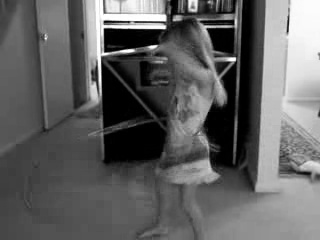

In [102]:
ppp

In [103]:
p = transform(ppp)

In [105]:
p.shape

torch.Size([1, 512, 512])

In [ ]:
import os
import pandas as pd

root = '/media/viplab/DATADRIVE1/huggingface/ucf101/train'
save_root = '/media/viplab/DATADRIVE1/driver_action_recognition/ucf101/train'
a = 1
for train_file in os.listdir(root):
    train_path = os.path.join(root, train_file)
    # print(train_path)
    df = pd.read_parquet(train_path)
    uni = df['label'].unique()
    ndf = pd.DataFrame(columns=df.columns)
    for i in uni:
        tdf = df[df['label'] == i]
        row = tdf.iloc[:5000]
        ndf = pd.concat([ndf, row], ignore_index=True)
    file_save_path = os.path.join(save_root, train_file)
    # print(file_save_path)
    ndf.to_parquet(file_save_path, engine = 'pyarrow', index = False)
    print(a)
    a += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [110]:
train_root = '/media/viplab/DATADRIVE1/driver_action_recognition/ucf101/train'

In [77]:
df['clip_id'].unique()

array(['v_HulaHoop_g14_c04', 'v_HulaHoop_g14_c05', 'v_HulaHoop_g15_c01',
       'v_HulaHoop_g15_c02', 'v_HulaHoop_g15_c03', 'v_HulaHoop_g15_c04',
       'v_HulaHoop_g15_c05', 'v_HulaHoop_g16_c01', 'v_HulaHoop_g16_c02',
       'v_HulaHoop_g16_c03', 'v_HulaHoop_g16_c04', 'v_HulaHoop_g16_c05',
       'v_HulaHoop_g16_c06', 'v_HulaHoop_g17_c01', 'v_HulaHoop_g17_c02',
       'v_HulaHoop_g17_c03', 'v_HulaHoop_g17_c04', 'v_HulaHoop_g17_c05',
       'v_HulaHoop_g18_c01', 'v_HulaHoop_g18_c02', 'v_HulaHoop_g18_c03',
       'v_HulaHoop_g18_c04', 'v_HulaHoop_g19_c01', 'v_HulaHoop_g19_c02',
       'v_HulaHoop_g19_c03', 'v_HulaHoop_g19_c04', 'v_HulaHoop_g20_c01',
       'v_HulaHoop_g20_c02', 'v_HulaHoop_g20_c03', 'v_HulaHoop_g20_c04',
       'v_HulaHoop_g20_c05', 'v_HulaHoop_g20_c06', 'v_HulaHoop_g20_c07',
       'v_HulaHoop_g21_c01', 'v_HulaHoop_g21_c02', 'v_HulaHoop_g21_c03',
       'v_HulaHoop_g21_c04', 'v_HulaHoop_g22_c01', 'v_HulaHoop_g22_c02',
       'v_HulaHoop_g22_c03', 'v_HulaHoop_g22_c04', 

In [80]:
df[df['clip_id'] == 'v_IceDancing_g09_c01']['label'].unique()

array([43])

In [13]:
for i in df.iloc:
    print(i)
    break

image       {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
video_id                                       v_HulaHoop_g14
clip_id                                    v_HulaHoop_g14_c04
frame                                                      78
label                                                      42
Name: 0, dtype: object


In [ ]:
for train_file in os.listdir(video_path):
    train_path = os.path.join(video_path, train_file)
    uni = df['video_id'].unique()
    samples = []
    for i in uni:
        tdf = df[df['video_id'] == i]
        temp = []
        print(i)
        for j in tdf.iloc:
            temp.append(transform(Image.open(io.BytesIO(j['image']['bytes'])).convert('L')))
            if len(temp) == 15:
                samples.append(temp)
                np.save('')
    

In [1]:
from PIL import Image
import io
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale
])
input_root = '/media/viplab/DATADRIVE1/huggingface/ucf101/test'
output_root = '/media/viplab/DATADRIVE1/driver_action_recognition/prevalid'
pp = os.listdir(input_root)
pp.remove('test-00013-of-00030.parquet')
for train_file in pp:
    train_path = os.path.join(input_root, train_file)
    print(train_path)
    df = pd.read_parquet(train_path)
    uni = df['clip_id'].unique()
    samples = []
    for i in uni:
        idx = 0
        tdf = df[df['clip_id'] == i]
        temp = []
        for j in range(len(tdf)):
            row = tdf.iloc[j]
            # print(transform(Image.open(io.BytesIO(row['image']['bytes'])).convert('L')).numpy())
            temp.append(transform(Image.open(io.BytesIO(row['image']['bytes'])).convert('L')).numpy())
            if len(temp) == 15:
                save_path = os.path.join(output_root, str(row['label']))
                os.makedirs(save_path, exist_ok=True)
                save_path = os.path.join(save_path, row['clip_id'] + '_' + str(j) + '.npy')
                # print(save_path, np.array(temp).shape)
                np.save(save_path, np.array(temp)) 
                temp = []

/media/viplab/DATADRIVE1/huggingface/ucf101/test/test-00000-of-00030.parquet
/media/viplab/DATADRIVE1/huggingface/ucf101/test/test-00001-of-00030.parquet


KeyboardInterrupt: 

In [ ]:
from datasets import load_dataset

data = load_dataset('flwrlabs/ucf101')

/home/viplab/miniconda3/envs/videomae2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pp

['test-00000-of-00030.parquet',
 'test-00001-of-00030.parquet',
 'test-00002-of-00030.parquet',
 'test-00003-of-00030.parquet',
 'test-00004-of-00030.parquet',
 'test-00005-of-00030.parquet',
 'test-00006-of-00030.parquet',
 'test-00007-of-00030.parquet',
 'test-00008-of-00030.parquet',
 'test-00009-of-00030.parquet',
 'test-00010-of-00030.parquet',
 'test-00011-of-00030.parquet',
 'test-00012-of-00030.parquet',
 'test-00014-of-00030.parquet',
 'test-00015-of-00030.parquet',
 'test-00016-of-00030.parquet',
 'test-00017-of-00030.parquet',
 'test-00018-of-00030.parquet',
 'test-00019-of-00030.parquet',
 'test-00020-of-00030.parquet',
 'test-00021-of-00030.parquet',
 'test-00022-of-00030.parquet',
 'test-00023-of-00030.parquet',
 'test-00024-of-00030.parquet',
 'test-00025-of-00030.parquet',
 'test-00026-of-00030.parquet',
 'test-00027-of-00030.parquet',
 'test-00028-of-00030.parquet',
 'test-00029-of-00030.parquet']

In [1]:
from PIL import Image
import io
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import re
from mamba_ssm import Mamba
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale
])
class VideoDataset(Dataset):
    def __init__(self, video_path):
        self.video_path = video_path
        self.samples = []
        for train_file in os.listdir(video_path):
            train_path = os.path.join(video_path, train_file)
            self.samples.append(train_path)
            
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_path = self.samples[idx]
        
        frames, labels = self.load_video_frames(video_path)  # Shape: (seq_len, height, width, channels)
        
        return frames, labels
    
    def load_video_frames(self, video_path):
        t_frames = []
        t_labels = []
        df = pd.read_parquet(video_path)
        uni = df['clip_id'].unique()
        for i in uni:
            tdf = df[df['clip_id'] == i]
            temp = []
            for j in tdf.iloc:
                temp.append(transform(Image.open(io.BytesIO(j['image']['bytes'])).convert('L')))
                if len(temp) == 5:
                    t_frames.append(temp)
                    t_labels.append(int(j['label']))
                    temp = []
        return t_frames, t_labels
        

In [3]:
train_root = '/media/viplab/DATADRIVE1/driver_action_recognition/ucf101/train'
train_dataset = VideoDataset(train_root)

In [4]:
print(len(train_dataset))

64


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True
)

In [6]:
for i in train_loader:
    print(i)
    break

RuntimeError: each element in list of batch should be of equal size

In [11]:
pp

,image,video_id,clip_id,frame,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyEyeMakeup_g08,v_ApplyEyeMakeup_g08_c01,1,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyEyeMakeup_g08,v_ApplyEyeMakeup_g08_c01,2,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyEyeMakeup_g08,v_ApplyEyeMakeup_g08_c01,3,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyEyeMakeup_g08,v_ApplyEyeMakeup_g08_c01,4,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyEyeMakeup_g08,v_ApplyEyeMakeup_g08_c01,5,0
...,...,...,...,...,...
9995,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,183,1
9996,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,184,1
9997,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,185,1
9998,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,186,1


In [4]:
ndf[ndf['label'] == 1]

,image,video_id,clip_id,frame,label
5000,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g08,v_ApplyLipstick_g08_c01,1,1
5001,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g08,v_ApplyLipstick_g08_c01,2,1
5002,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g08,v_ApplyLipstick_g08_c01,3,1
5003,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g08,v_ApplyLipstick_g08_c01,4,1
5004,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g08,v_ApplyLipstick_g08_c01,5,1
...,...,...,...,...,...
9995,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,183,1
9996,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,184,1
9997,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,185,1
9998,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,v_ApplyLipstick_g14,v_ApplyLipstick_g14_c02,186,1


In [5]:
df = pd.read_parquet('/media/viplab/DATADRIVE1/huggingface/ucf101/train/train-00001-of-00064.parquet')

In [9]:
df['label'].unique()

array([1, 2, 3])

In [51]:
s

{-1.0,
 -0.9921568632125854,
 -0.9843137264251709,
 -0.9764705896377563,
 -0.9686274528503418,
 -0.9607843160629272,
 -0.9529411792755127,
 -0.9450980424880981,
 -0.9372549057006836,
 -0.929411768913269,
 -0.9215686321258545,
 -0.9137254953384399,
 -0.9058823585510254,
 -0.8980392217636108,
 -0.8901960849761963,
 -0.8823529481887817,
 -0.8745098114013672,
 -0.8666666746139526,
 -0.8588235378265381,
 -0.8509804010391235,
 -0.843137264251709,
 -0.8352941274642944,
 -0.8274509906768799,
 -0.8196078538894653,
 -0.8117647171020508,
 -0.8039215803146362,
 -0.7960784435272217,
 -0.7882353067398071,
 -0.7803921699523926,
 -0.772549033164978,
 -0.7647058963775635,
 -0.7568627595901489,
 -0.7490196228027344,
 -0.7411764860153198,
 -0.7333333492279053,
 -0.7254902124404907,
 -0.7176470756530762,
 -0.7098039388656616,
 -0.7019608020782471,
 -0.6941176652908325,
 -0.686274528503418,
 -0.6784313917160034,
 -0.6705882549285889,
 -0.6627451181411743,
 -0.6549019813537598,
 -0.6470588445663452,
 -0.639

In [49]:
k.item()

-1.0

In [1]:
from causal_conv1d import causal_conv1d_fn, causal_conv1d_update

In [4]:
from conv1d import causal_conv1d_fn, causal_conv1d_update

ModuleNotFoundError: No module named 'conv1d'

In [5]:
import torchvision.models.video as video_models
model = video_models.r3d_18(weights='DEFAULT')

In [ ]:
model
self.model.fc = torch.nn.Linear(model.head.in_features, num_classes)
conv3d_weights = model.stem[0].weight  

averaged_weights = conv3d_weights.mean(dim=1, keepdim=True)
self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
self.model.stem[0].weight.data = averaged_weights

IndentationError: unexpected indent (3039647223.py, line 2)

In [28]:
import torch
x = torch.randn(8,3, 15, 224, 224)

In [30]:
y =model(x)

In [32]:
y.shape

torch.Size([8, 400])

In [22]:
model.stem

BasicStem(
  (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
  (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [17]:
for i in model.stem:
    print(i)

Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
